# Workshop - $\textit{Hands On}$!
## Versão Completa

In [ ]:
#Comando para instalar tensorflow
!pip install tensorflow

In [ ]:
#Comando para instalar tensorflow com suporte a GPU (apenas rexecute esta célula se tiver uma GPU com CUDA e cuDNN!!!!)
!pip install-tensorflow-gpu

In [ ]:
# Comando para instalar os pacotes necessários
!pip install numpy pandas matplotlib seaborn sklearn xgboost keras

In [4]:
import tensorflow
tensorflow.logging.set_verbosity(tensorflow.logging.ERROR)
from keras import models
from keras import layers
from keras import optimizers

In [5]:
# Rodar apenas se estiver rodando GPU localmente e tiver problemas com alocação de memória!!
import tensorflow
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
from keras.backend.tensorflow_backend import set_session
set_session(tensorflow.Session(config=config))

In [6]:
import numpy
import pandas
import xgboost
import seaborn
from sklearn import svm
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import neighbors
from matplotlib import pyplot
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import model_selection

In [7]:
tensorflow.logging.set_verbosity(tensorflow.logging.ERROR)
seaborn.set_style("darkgrid")
models_list = {}
auc_list = {}

# Introdução

<p>Neste <i>workshop</i> serão feitas várias demostrações de modelos de aprendizado para classificação supervisionada, utilizando algoritmos de aprendizado linear, estatístico, diferentes tipos de <i>ensembles</i> e ao final um exemplo com uma rede neural construída com o <i>Keras</i>.</p>

# Leitura e Análise Dos Dados

A nossa base de dados é um compilado de informações sobre exoplanetas da NASA (proveniente do [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html)) que possui várias informações sobre planetas confirmados exoplanetas e falsos positivos.

In [8]:
df = pandas.read_csv("koi_database.csv")
classes = ["Confirmados", "Falsos Positivos"]
df.head()

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [9]:
print("Linhas:", df.shape[0])
print("Colunas:", df.shape[1])

Linhas: 9564
Colunas: 49


Aqui vamos eliminar colunas desnecessárias para o aprendizado, e também colunas que enviesam os algoritmos (informações disponíveis após a confirmação).

In [10]:
df = df.drop(["kepoi_name", "kepid", "kepler_name", "koi_fpflag_nt", "koi_score", "koi_pdisposition", "koi_tce_delivname", "koi_teq_err1", "koi_teq_err2", "koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec"], axis=1)
df = df[df["koi_disposition"] != "CANDIDATE"]
df = df.dropna()
df.head()

,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,CONFIRMED,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
3,FALSE POSITIVE,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,CONFIRMED,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,CONFIRMED,11.094321,2.036000e-05,-2.036000e-05,171.201160,0.001410,-0.001410,0.538,0.030,-0.428,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


Aqui aplicamos <i>one-hot encoding</i> na base para determinarmos as classes 0 e 1.

In [11]:
df["koi_disposition"] = df["koi_disposition"].apply(lambda x: 1 if x == "CONFIRMED" else 0)
df.head()

,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,1,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
3,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,1,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,1,11.094321,2.036000e-05,-2.036000e-05,171.201160,0.001410,-0.001410,0.538,0.030,-0.428,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


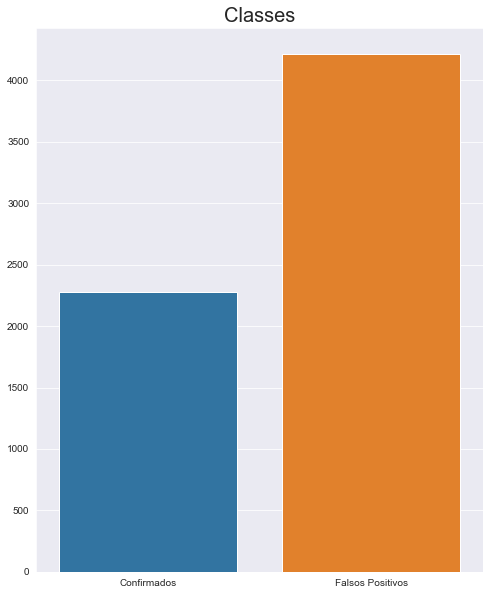

Confirmados: 2282
Falsos Positivos: 4215


In [12]:
y = df["koi_disposition"]
pyplot.subplots(figsize=(8, 10))
seaborn.barplot(data=pandas.DataFrame({"Confirmados": y.sum(), "Falsos Positivos": y.size - y.sum()}, index=classes)).set_title("Classes", fontsize=20)
pyplot.show()
print("Confirmados:", y.sum())
print("Falsos Positivos:", y.size - y.sum())

Aui é feita a normalização <i>z-score</i> em nossos dados para ajudar na perda dos modelos.

In [13]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(df.iloc[:, 1:], df.iloc[:, 0], test_size=0.33, random_state=42)
mi = numpy.mean(x_train)
sigma = numpy.std(x_train)
x_train = (x_train - mi) / sigma
x_test = (x_test - mi) / sigma

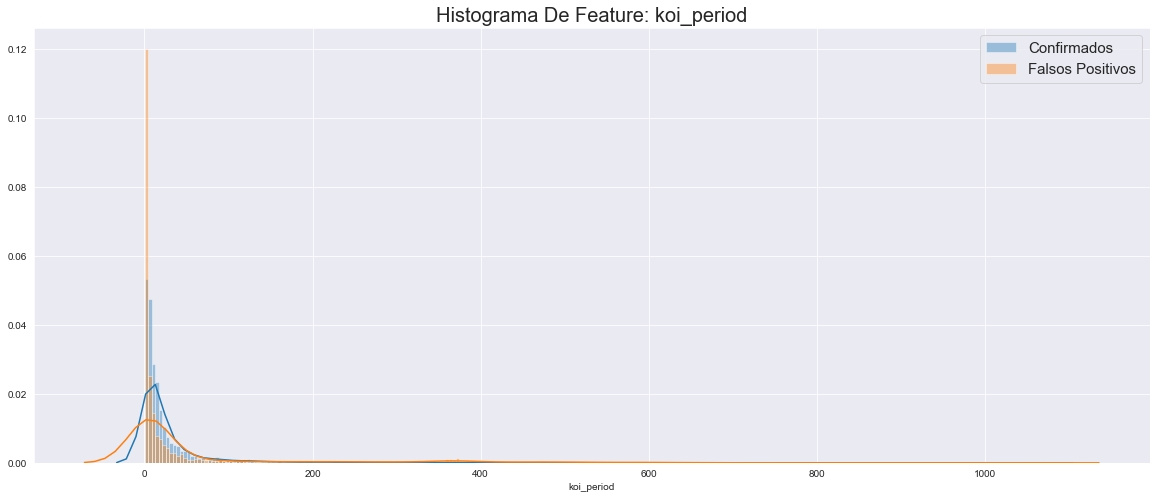

                      Média     Variância
Confirmados       26.972349   2743.508267
Falsos Positivos  57.514776  16129.275268


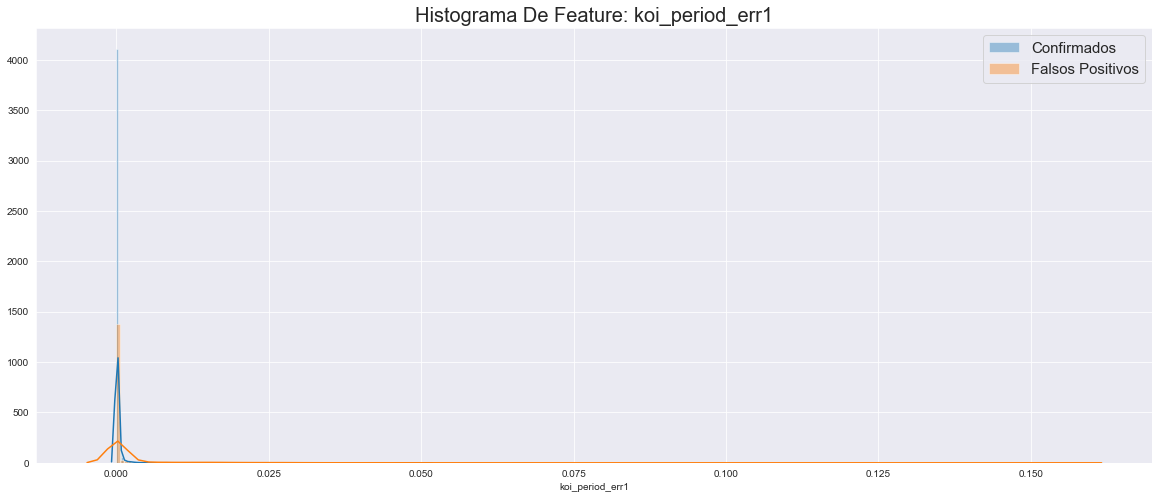

                     Média  Variância
Confirmados       0.000217   0.000002
Falsos Positivos  0.002175   0.000073


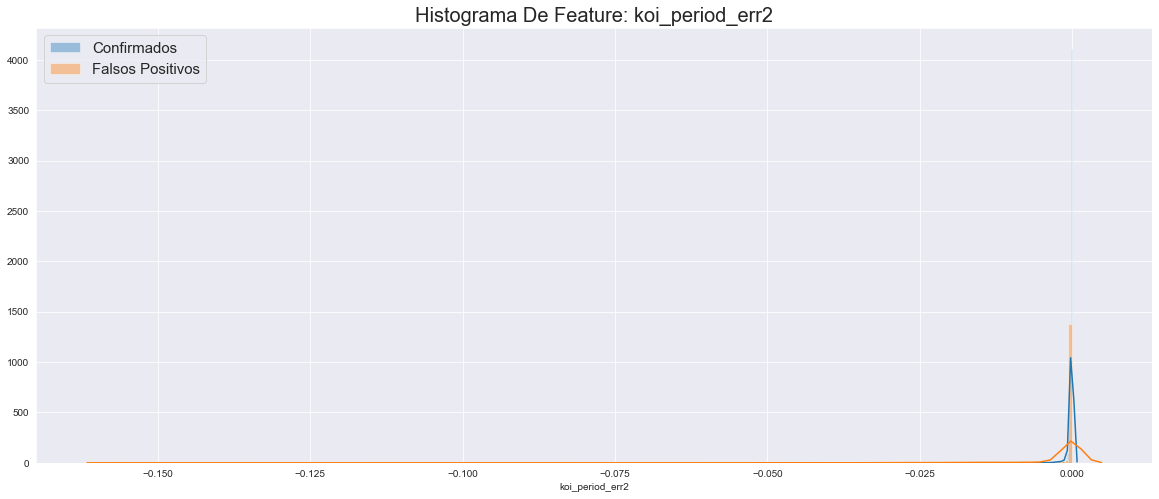

                     Média  Variância
Confirmados      -0.000217   0.000002
Falsos Positivos -0.002175   0.000073


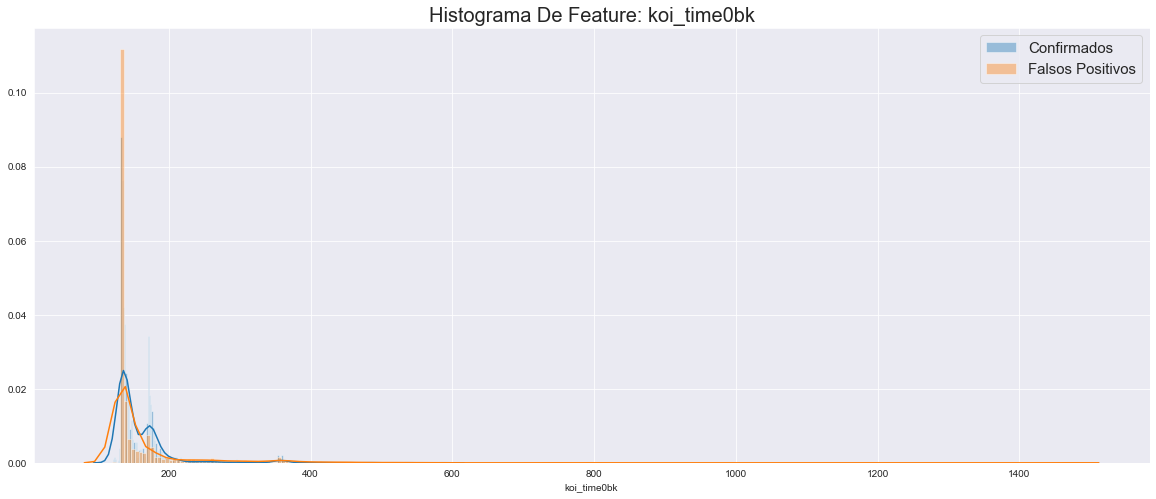

                       Média    Variância
Confirmados       157.126242  1765.406428
Falsos Positivos  162.961898  4946.619106


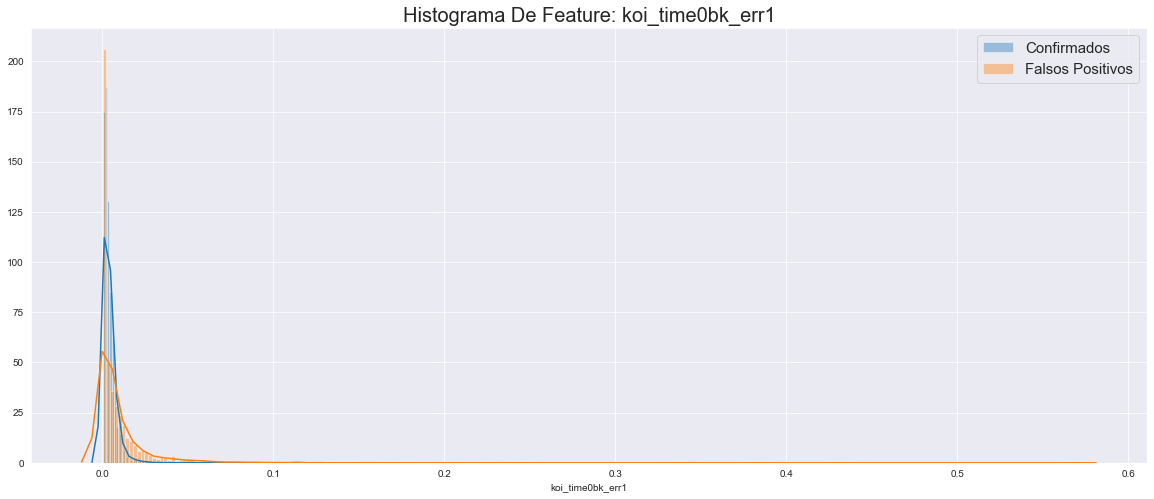

                     Média  Variância
Confirmados       0.004204   0.000093
Falsos Positivos  0.009324   0.000465


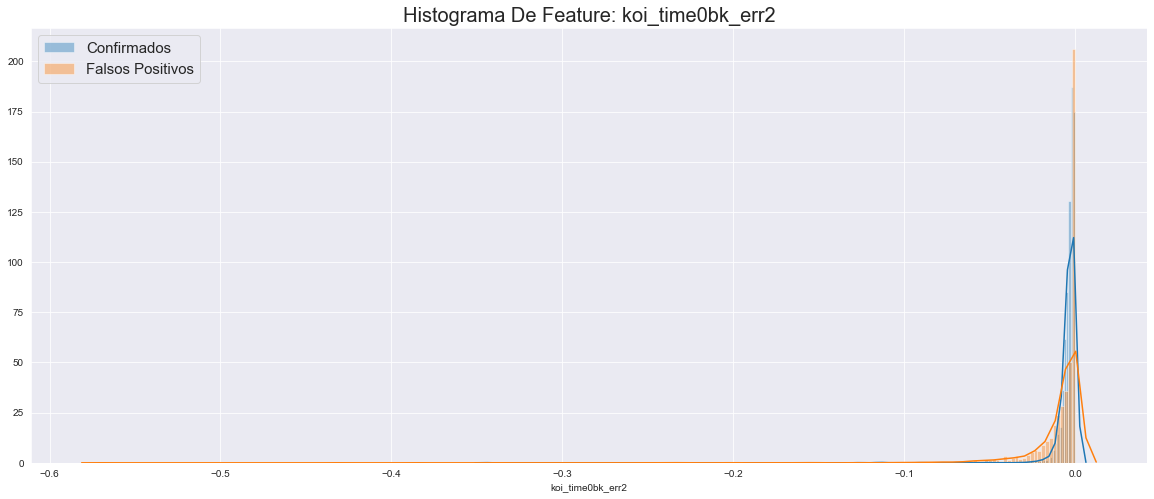

                     Média  Variância
Confirmados      -0.004204   0.000093
Falsos Positivos -0.009324   0.000465


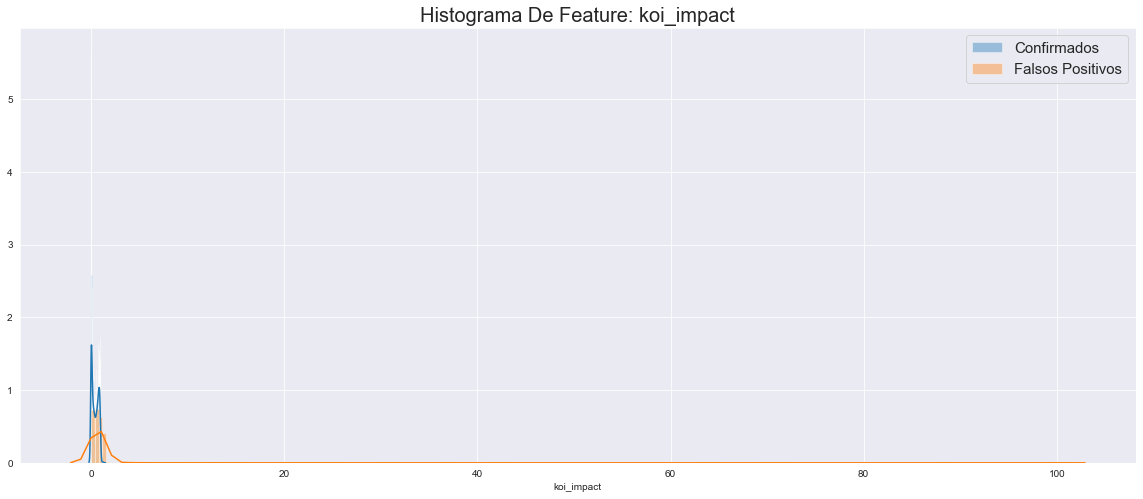

                     Média  Variância
Confirmados       0.427272   0.110982
Falsos Positivos  0.922863  14.048325


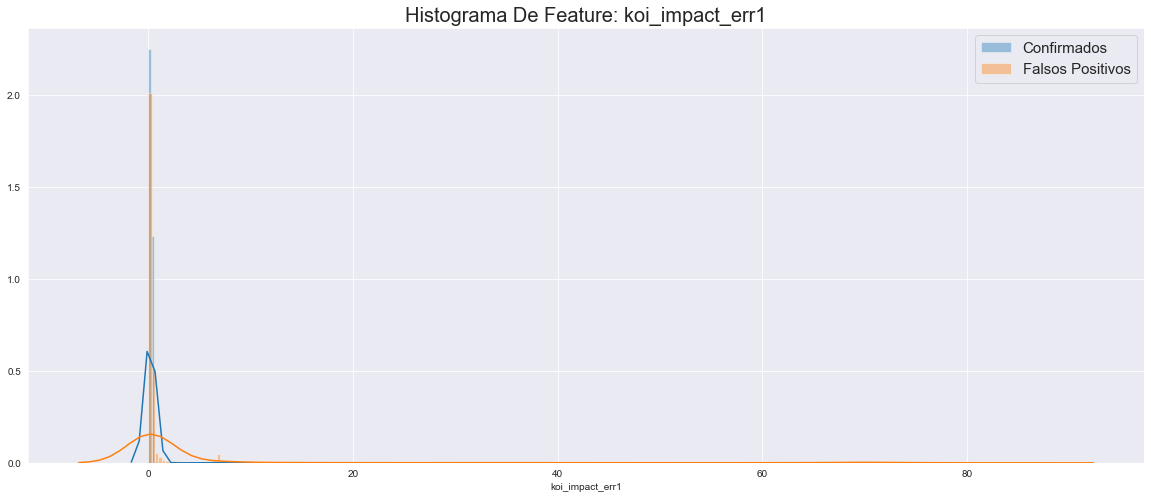

                     Média  Variância
Confirmados       0.301999    6.64890
Falsos Positivos  3.157508  143.67185


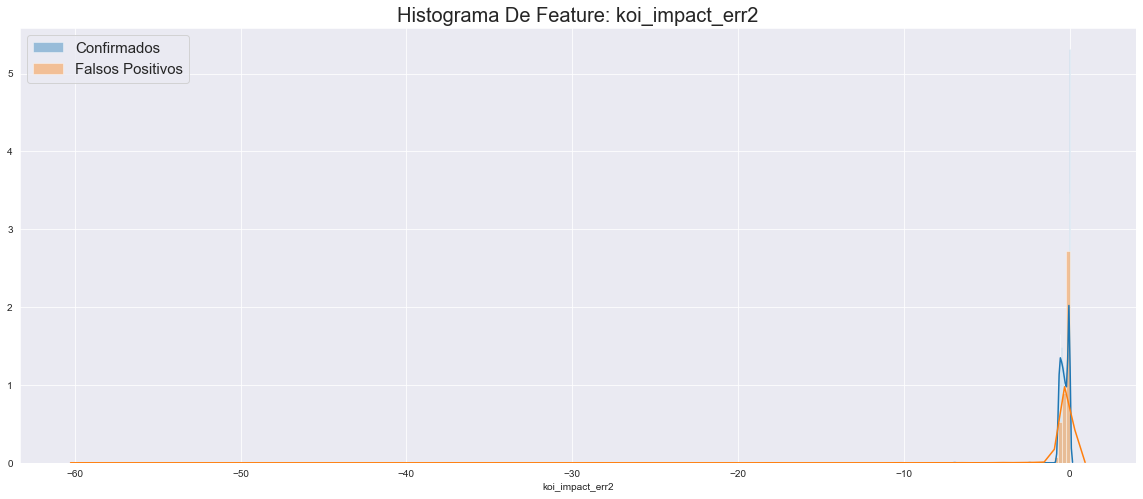

                     Média  Variância
Confirmados      -0.311153   0.073320
Falsos Positivos -0.324208   2.704101


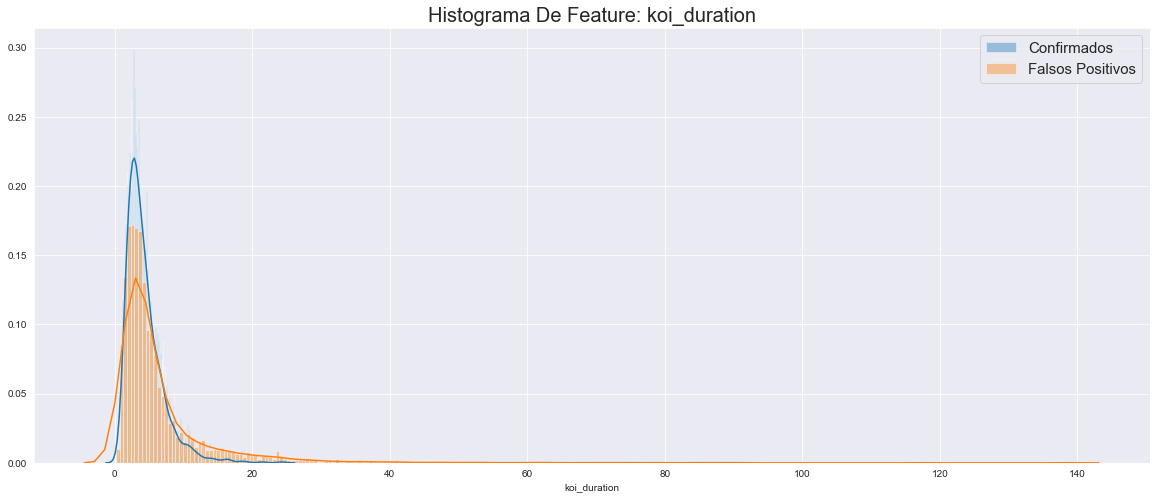

                     Média  Variância
Confirmados       4.310305   7.356293
Falsos Positivos  6.458883  66.200273


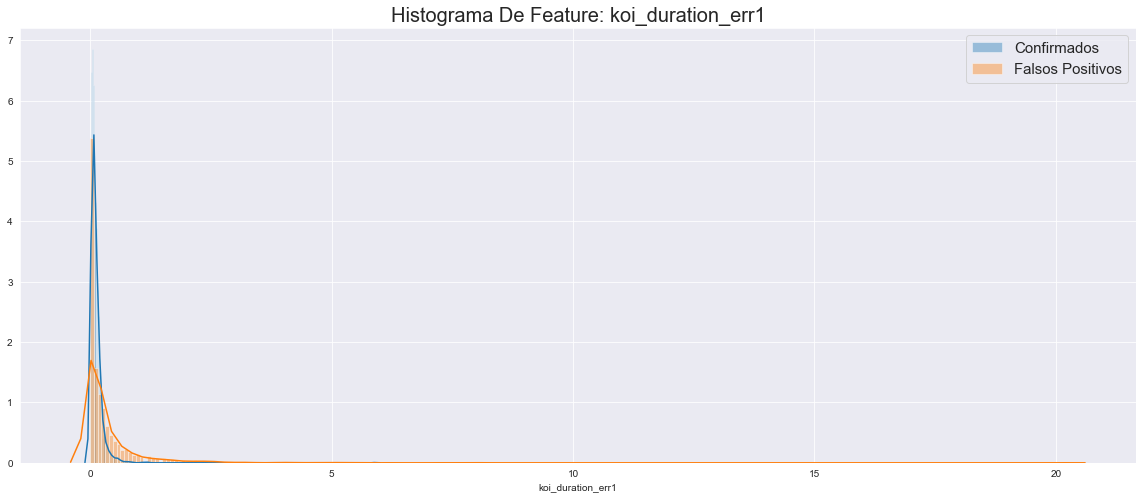

                     Média  Variância
Confirmados       0.122438   0.027328
Falsos Positivos  0.350884   0.507988


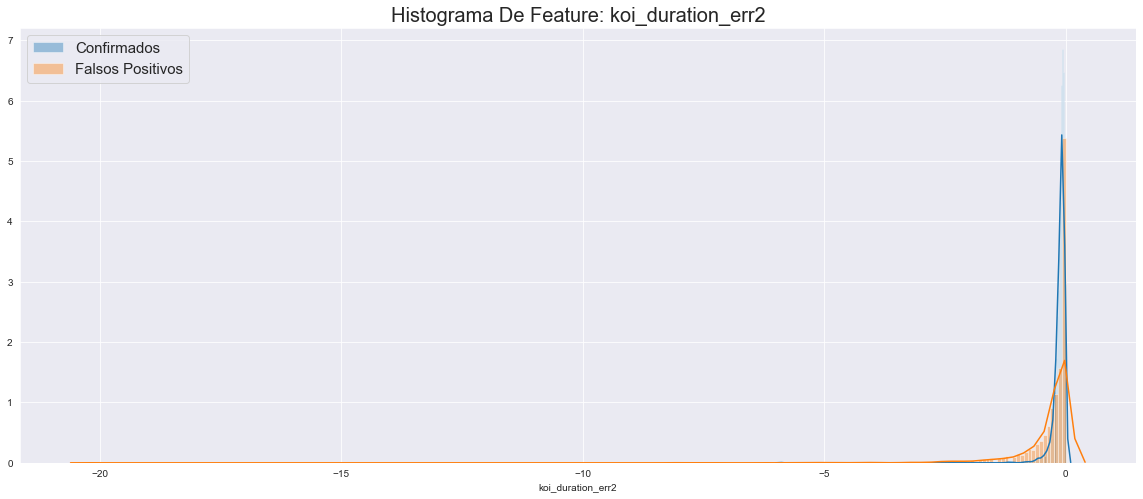

                     Média  Variância
Confirmados      -0.122438   0.027328
Falsos Positivos -0.350884   0.507988


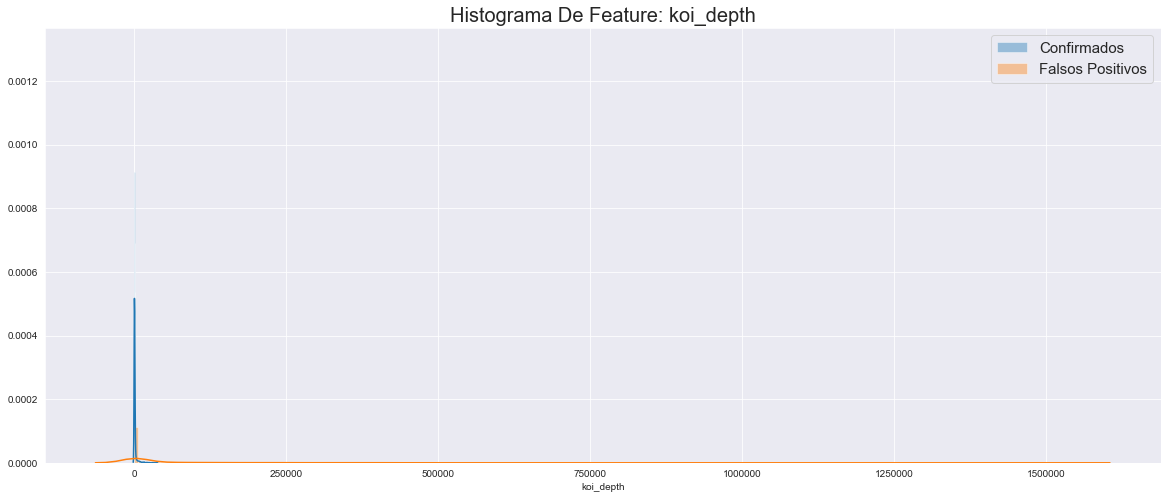

                         Média     Variância
Confirmados        1146.515294  7.288732e+06
Falsos Positivos  47684.690700  1.276959e+10


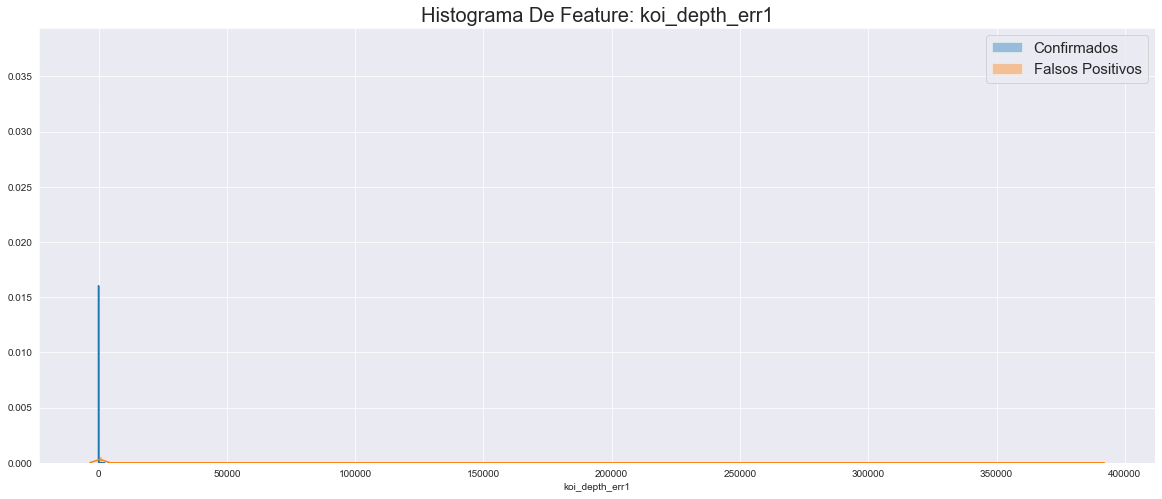

                       Média     Variância
Confirmados        22.446538  5.471013e+03
Falsos Positivos  214.322633  3.650664e+07


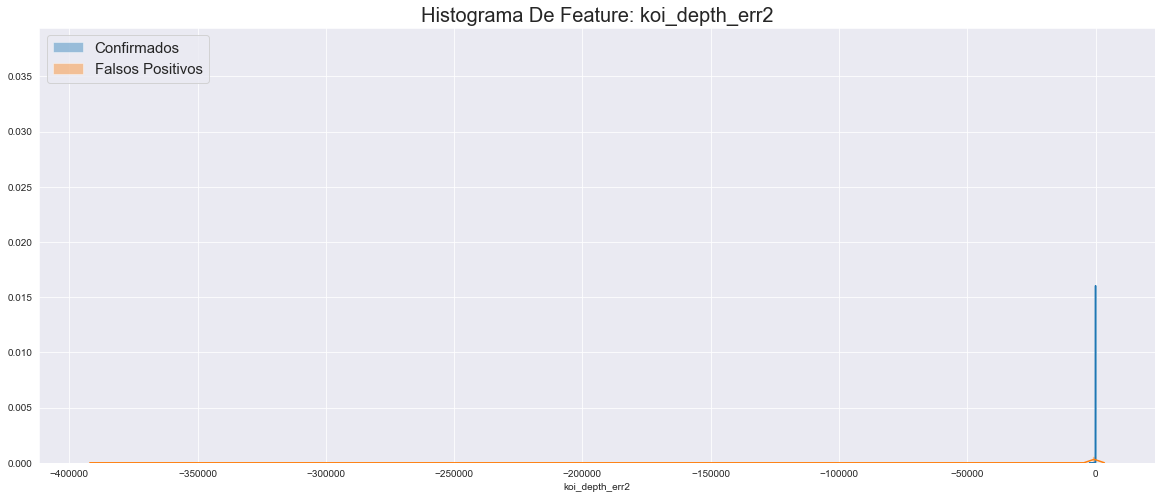

                       Média     Variância
Confirmados       -22.446538  5.471013e+03
Falsos Positivos -214.322633  3.650664e+07


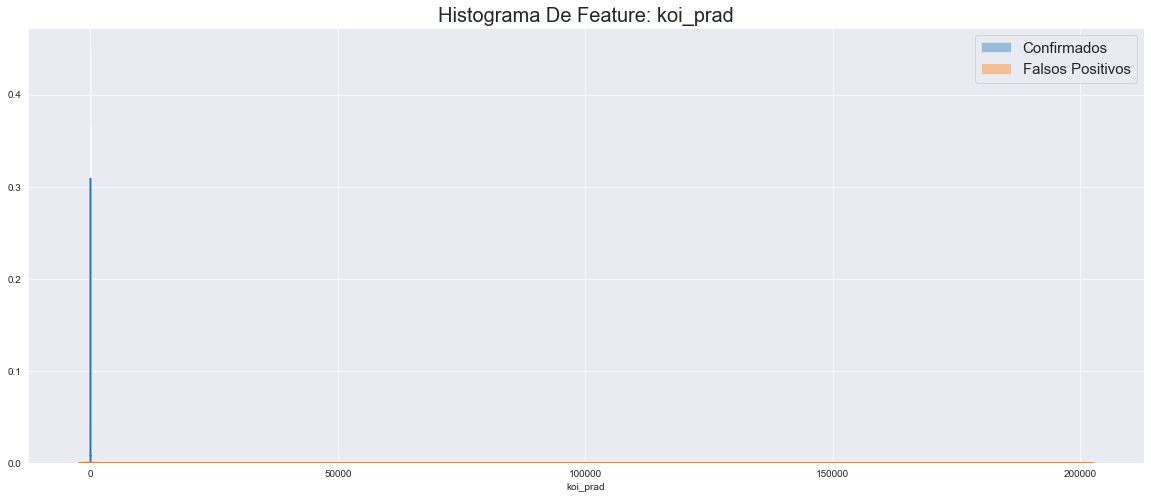

                       Média     Variância
Confirmados         2.889137  1.156157e+01
Falsos Positivos  170.349179  1.749928e+07


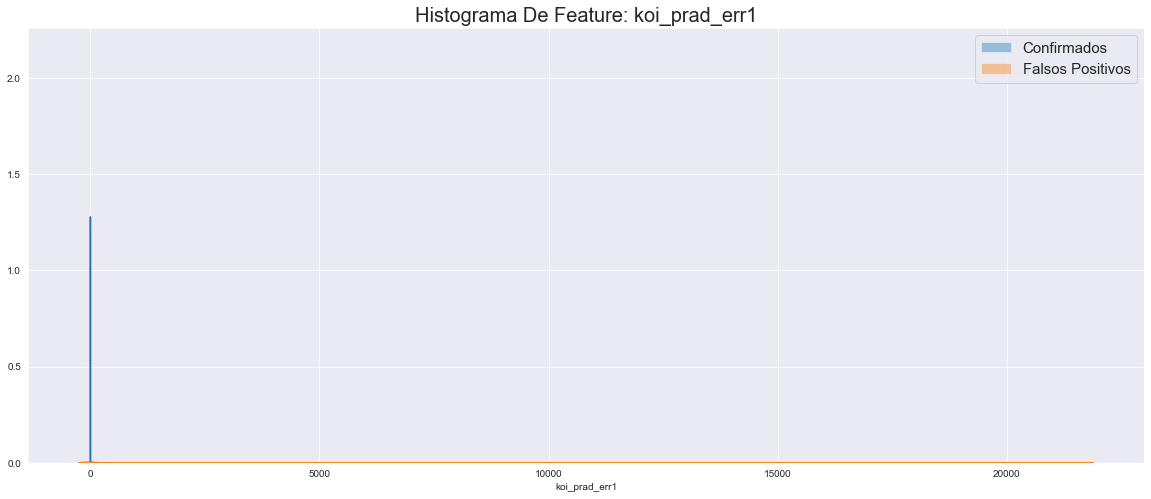

                      Média      Variância
Confirmados        0.480241       0.657939
Falsos Positivos  25.509853  201395.634970


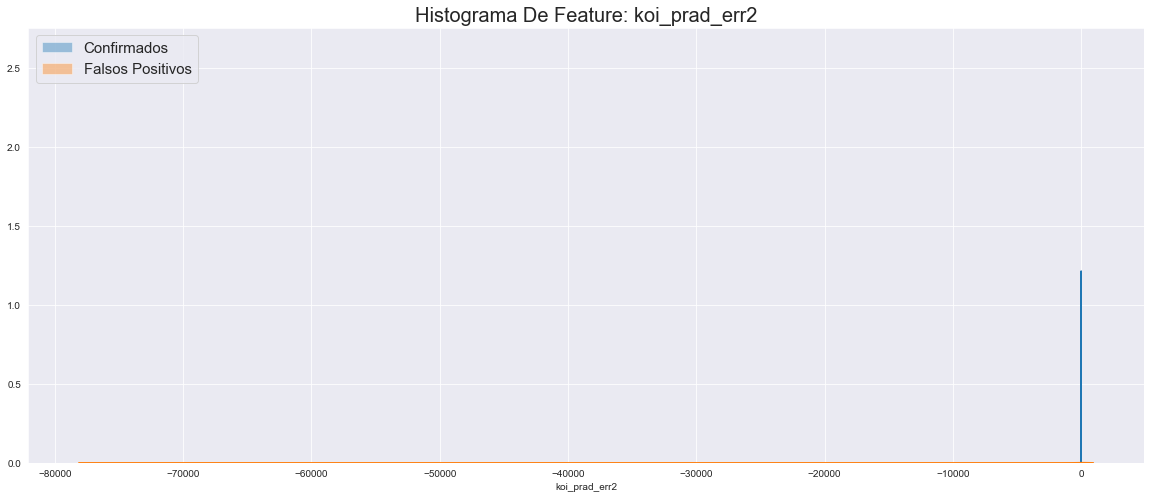

                     Média     Variância
Confirmados       -0.38979  9.097717e-01
Falsos Positivos -58.09675  2.826668e+06


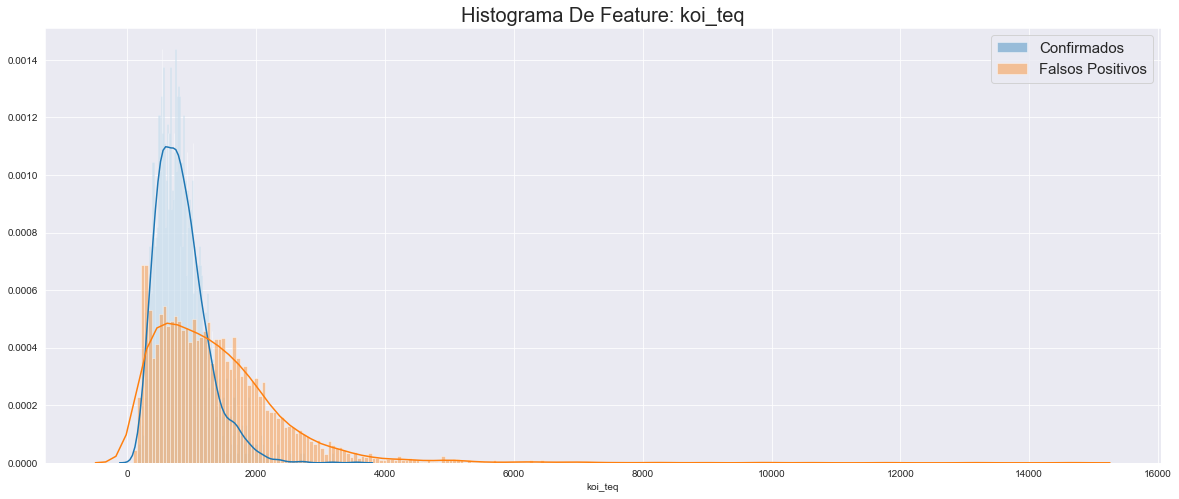

                       Média     Variância
Confirmados        839.28440  1.504911e+05
Falsos Positivos  1368.72503  1.077936e+06


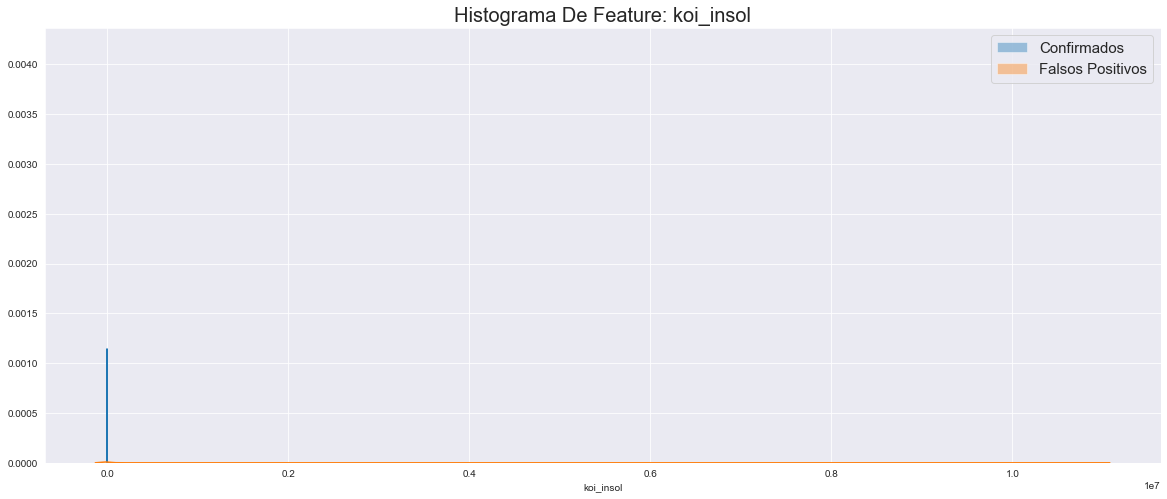

                         Média     Variância
Confirmados         352.567831  1.508118e+06
Falsos Positivos  14315.479718  5.235036e+10


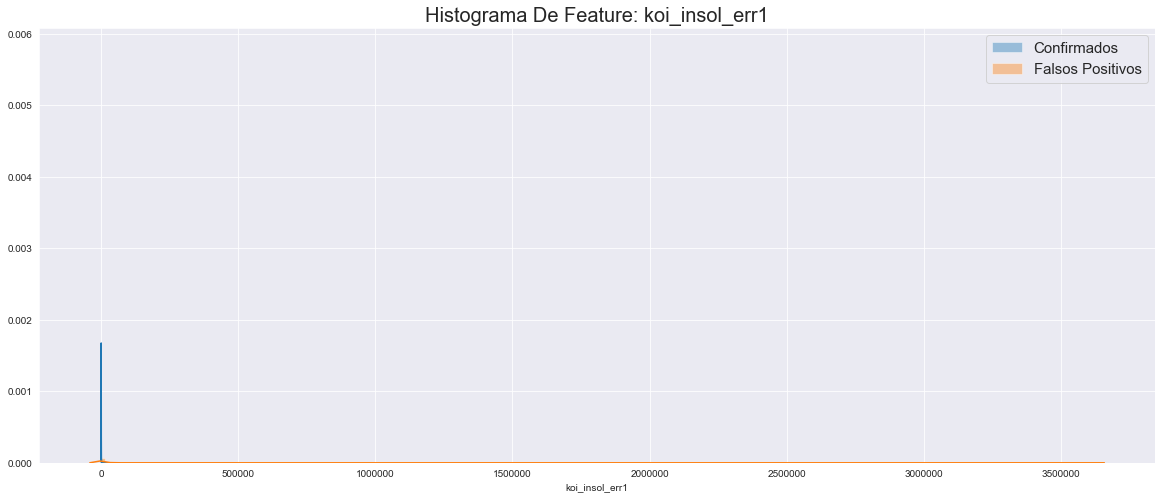

                        Média     Variância
Confirmados        188.920824  7.768302e+05
Falsos Positivos  6563.125499  5.376366e+09


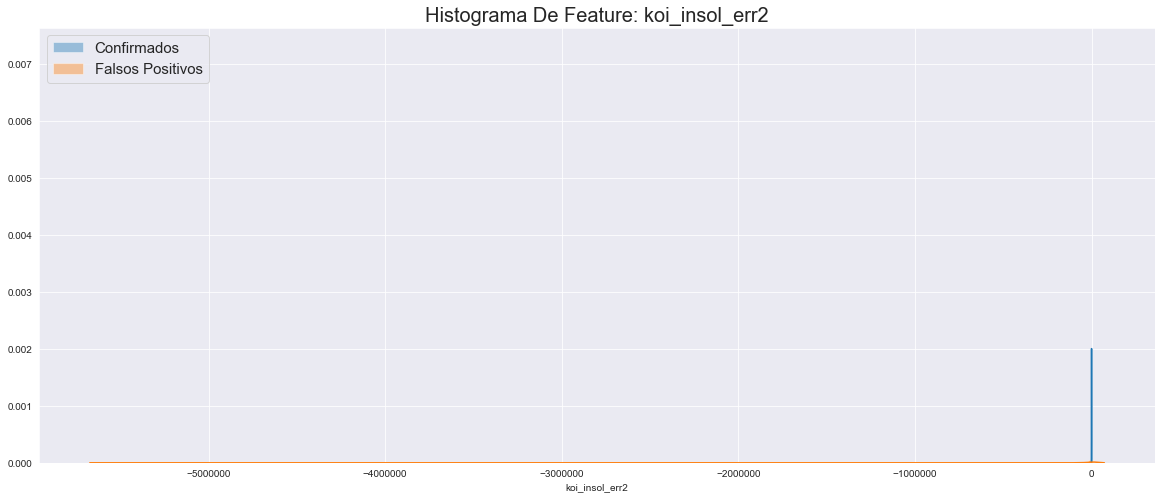

                        Média     Variância
Confirmados       -133.266109  6.069075e+05
Falsos Positivos -7542.078975  1.636415e+10


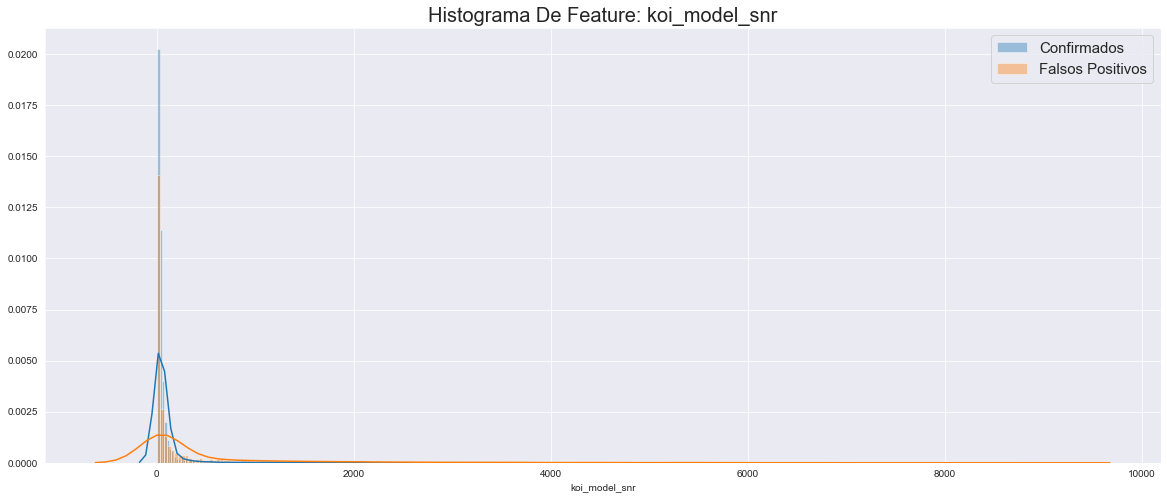

                       Média     Variância
Confirmados        88.036284  8.100576e+04
Falsos Positivos  492.891554  1.221616e+06


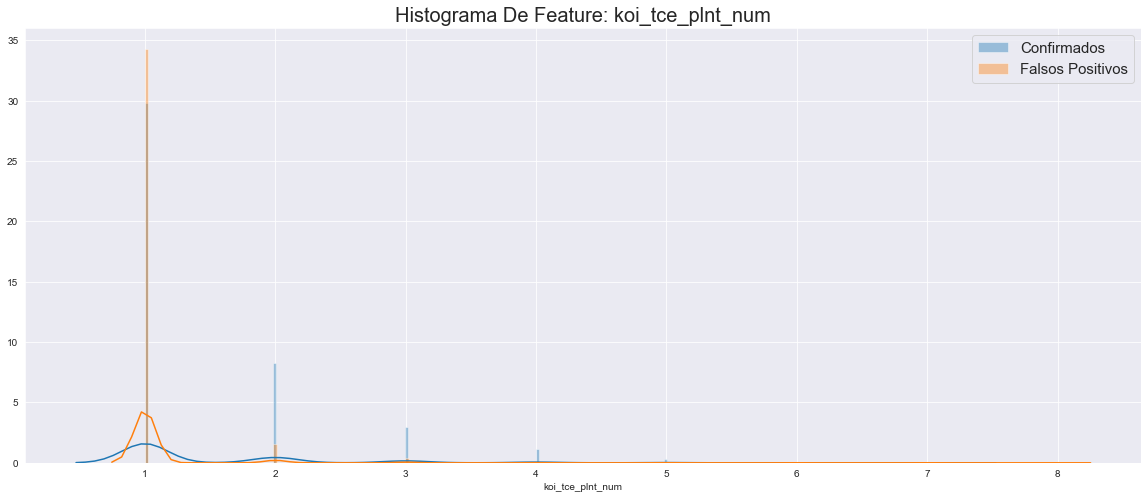

                     Média  Variância
Confirmados       1.454864   0.682669
Falsos Positivos  1.093238   0.201746


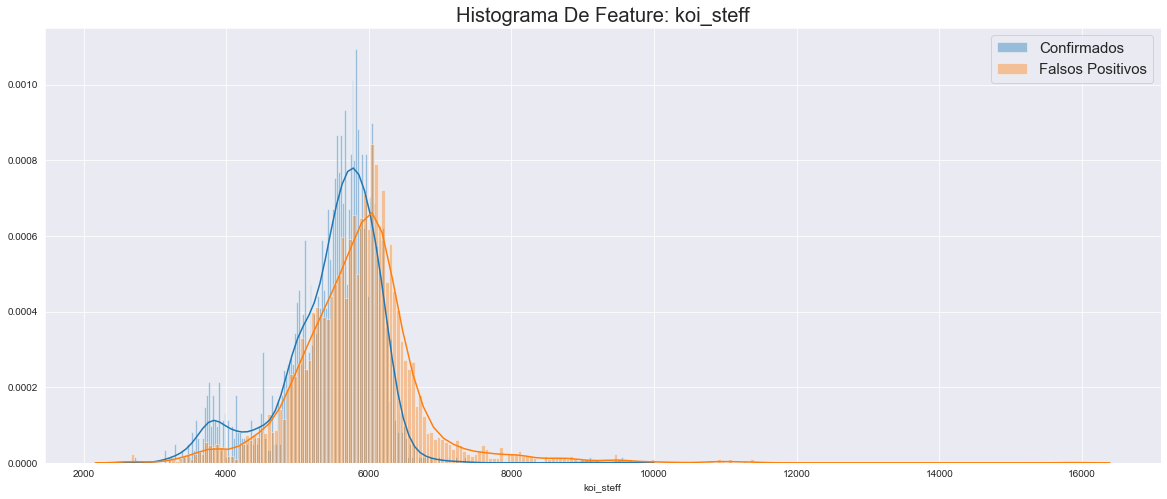

                        Média      Variância
Confirmados       5478.555653  462593.320522
Falsos Positivos  5850.095136  769922.635552


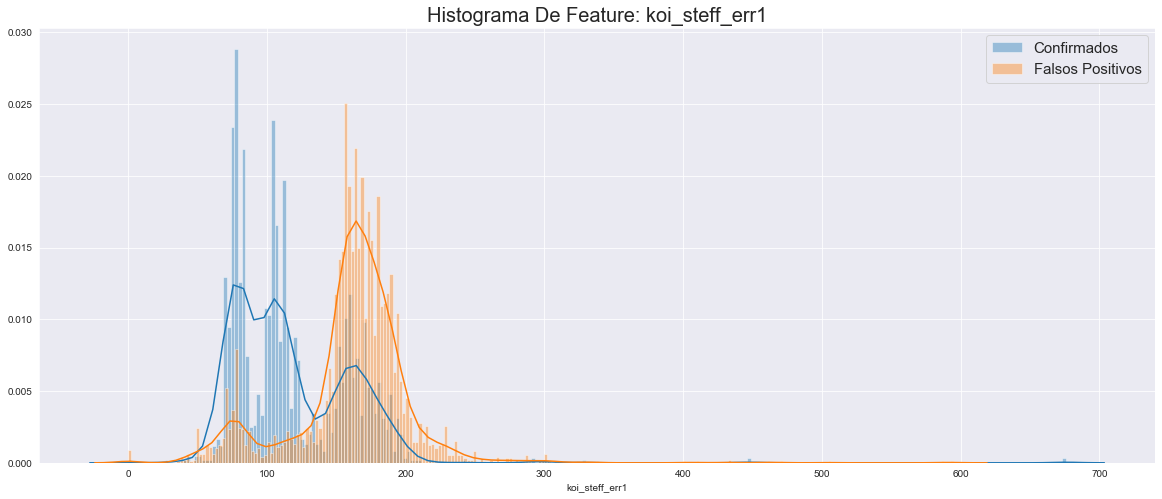

                       Média    Variância
Confirmados       116.931201  1865.360297
Falsos Positivos  161.197865  1809.533803


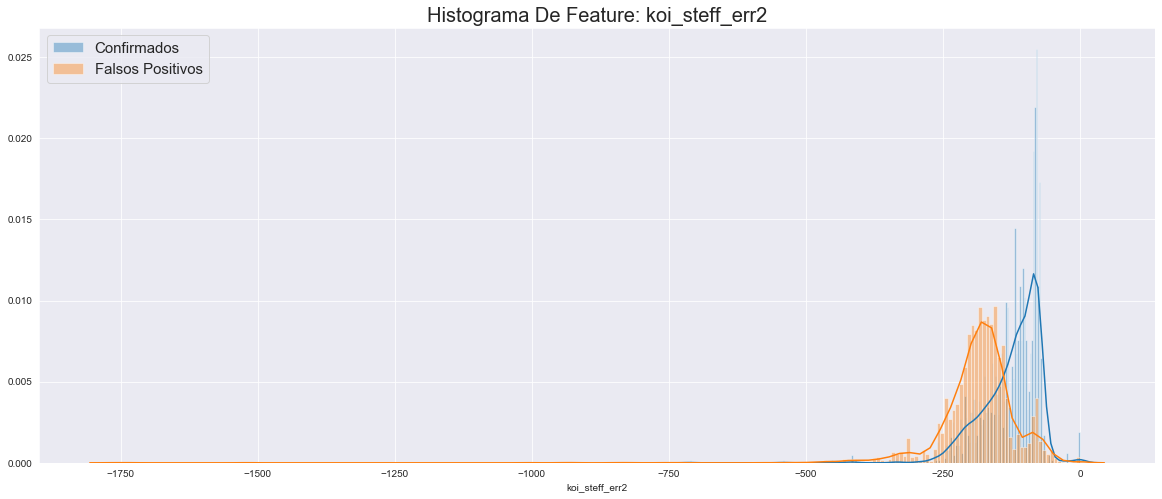

                       Média    Variância
Confirmados      -124.238826  2719.465749
Falsos Positivos -185.327402  6181.209534


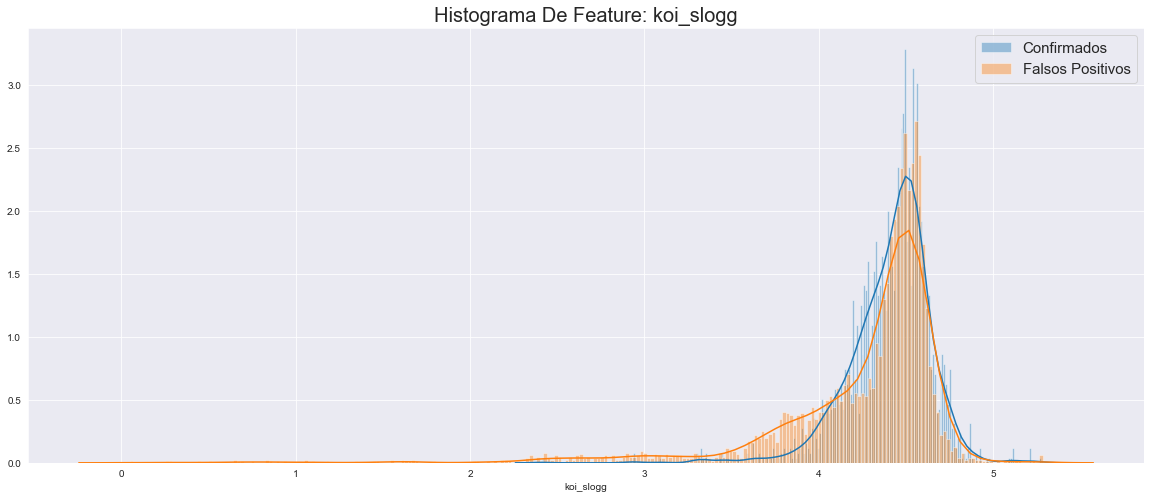

                     Média  Variância
Confirmados       4.410516   0.055671
Falsos Positivos  4.246303   0.265850


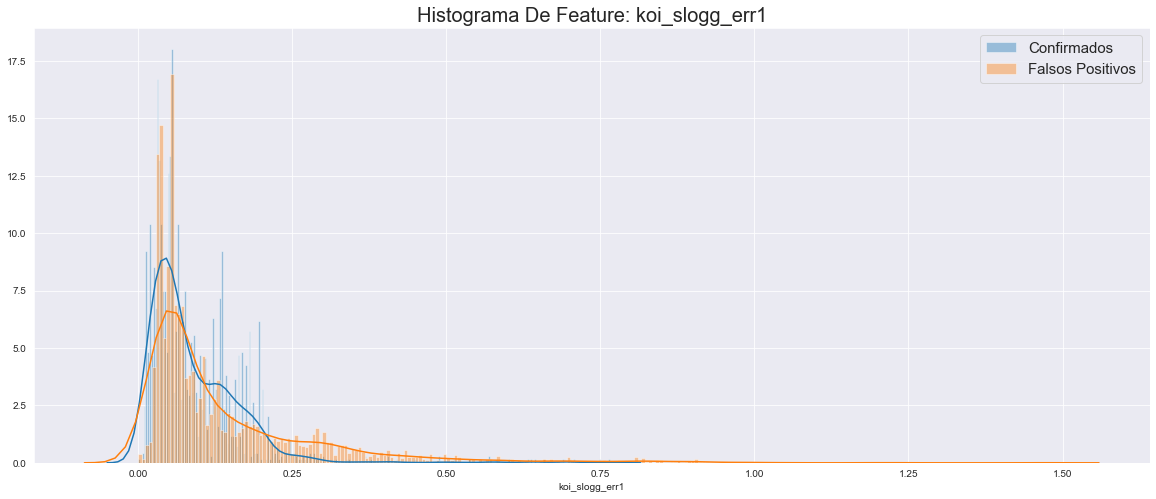

                     Média  Variância
Confirmados       0.089879   0.006222
Falsos Positivos  0.141212   0.023774


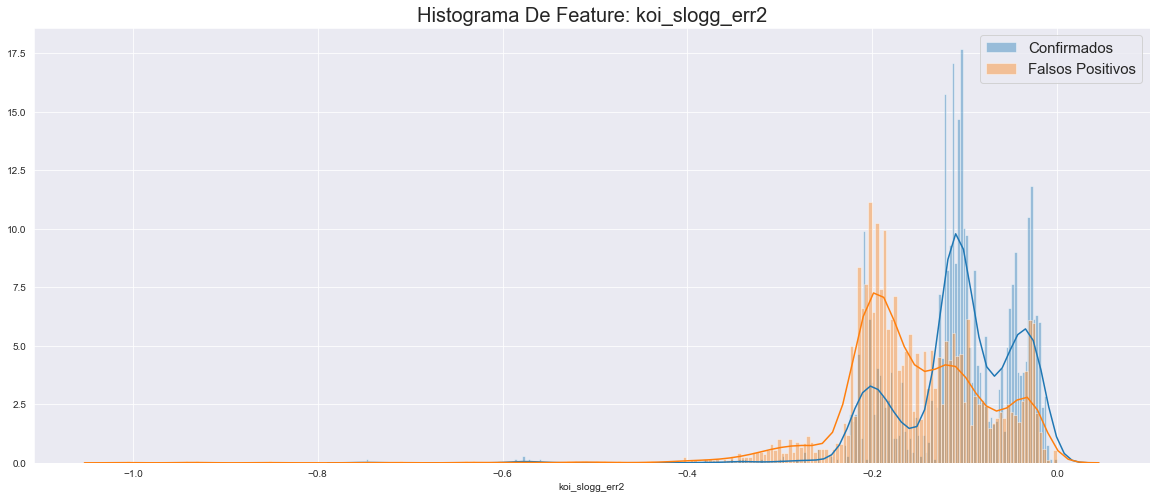

                     Média  Variância
Confirmados      -0.106178   0.004195
Falsos Positivos -0.155468   0.006453


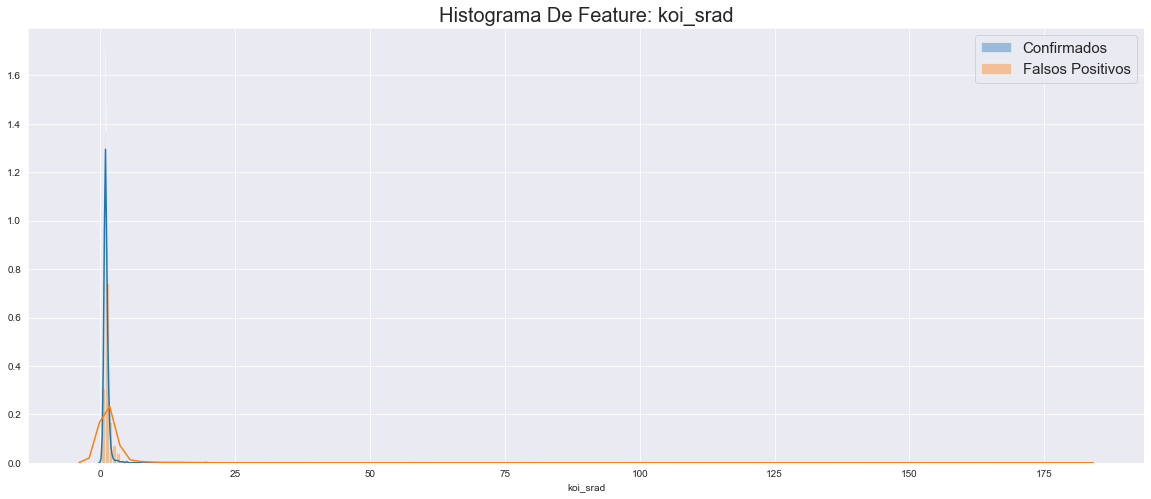

                     Média  Variância
Confirmados       1.067479   0.416104
Falsos Positivos  2.141947  52.868525


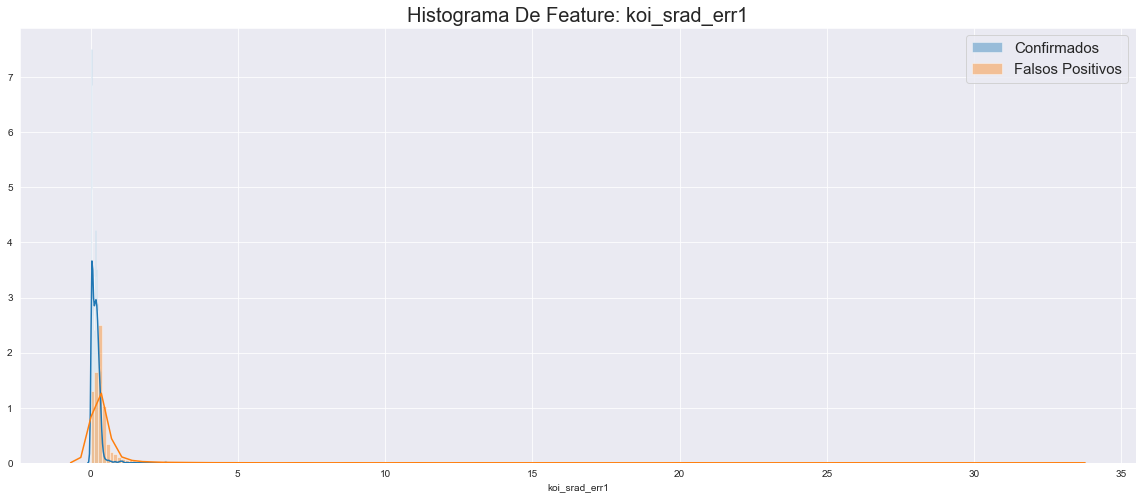

                     Média  Variância
Confirmados       0.175544   0.020668
Falsos Positivos  0.458356   1.444793


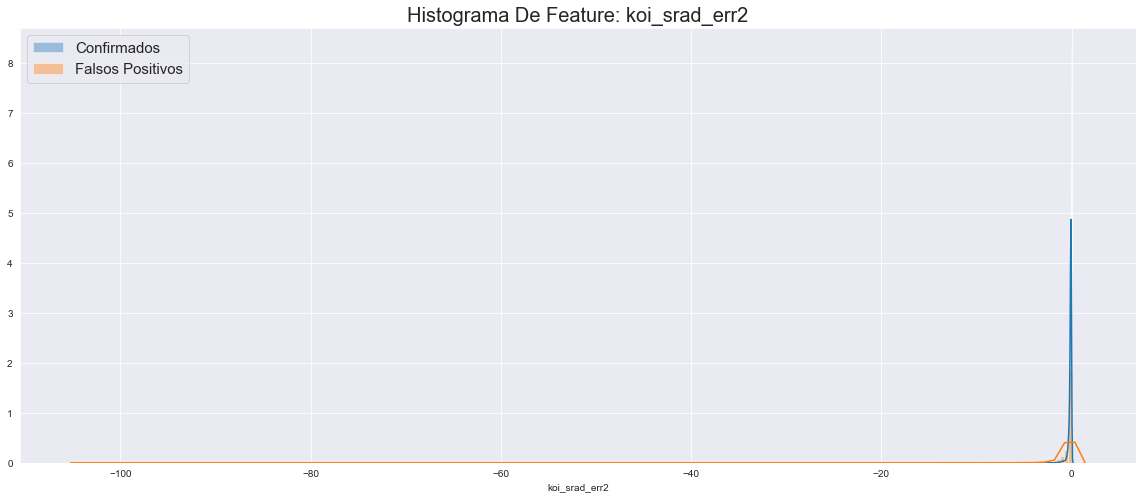

                     Média  Variância
Confirmados      -0.150011   0.051175
Falsos Positivos -0.543946   6.247664


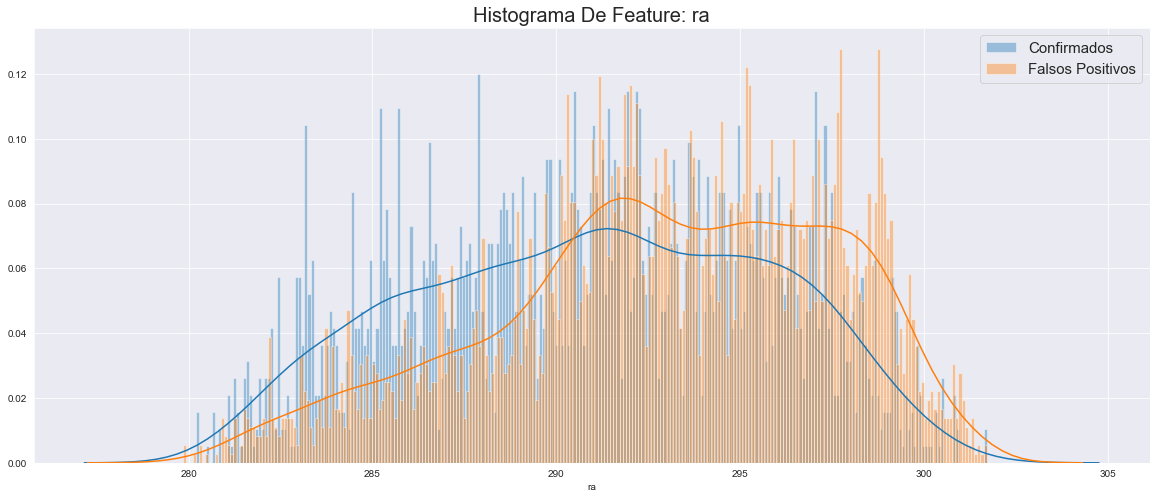

                       Média  Variância
Confirmados       290.955675  22.661826
Falsos Positivos  292.845778  21.307899


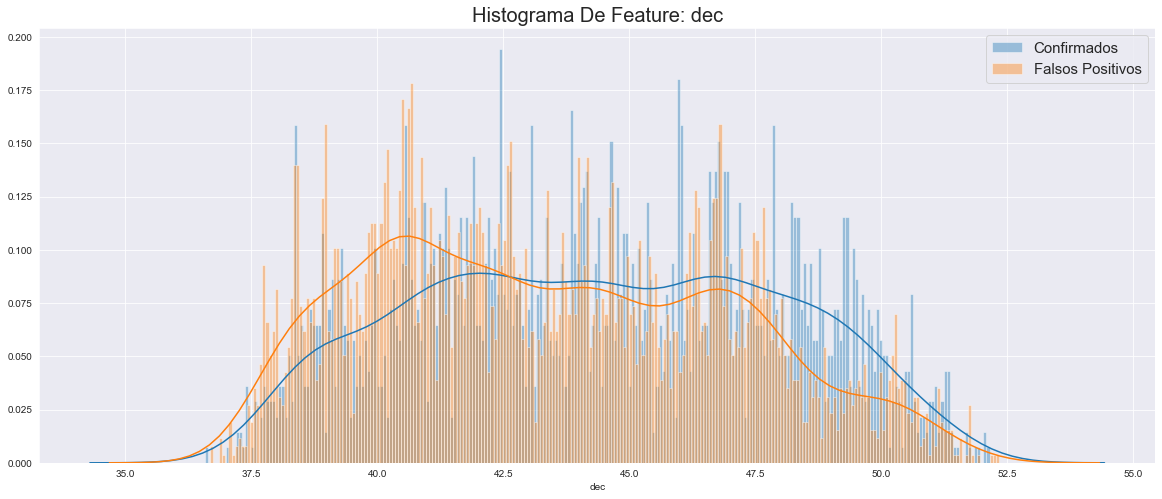

                      Média  Variância
Confirmados       44.381184  12.742088
Falsos Positivos  43.422299  12.480009


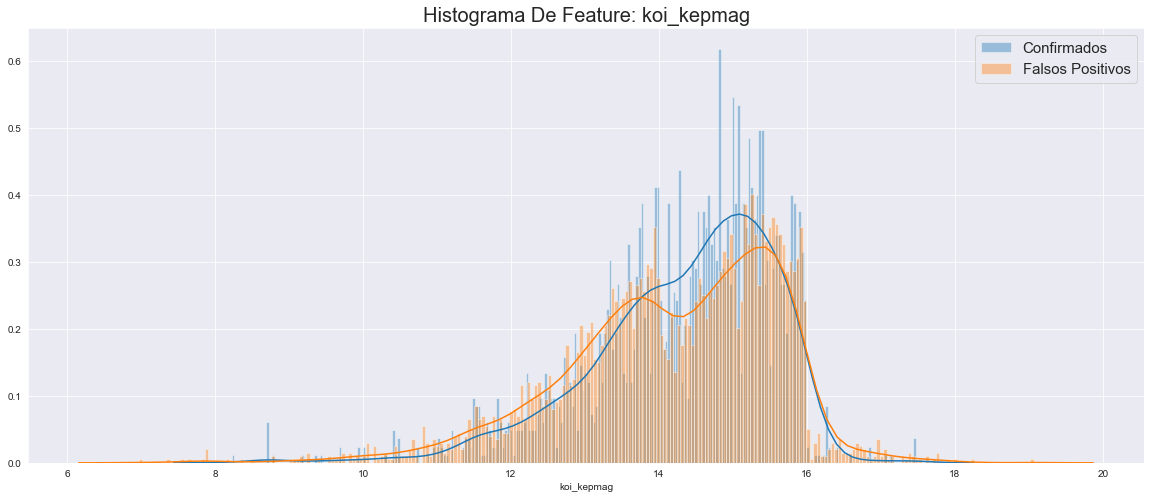

                      Média  Variância
Confirmados       14.341218   1.504839
Falsos Positivos  14.188406   2.038524


In [14]:
for i in df.columns[1:]:
    _, axis = pyplot.subplots(figsize=(20, 8))
    seaborn.distplot(df[i][df["koi_disposition"] == 1], bins=256, label="Confirmados")
    seaborn.distplot(df[i][df["koi_disposition"] == 0], bins=256, label="Falsos Positivos")
    axis.set_title("Histograma De Feature: " + i,fontsize=20)
    pyplot.legend(fontsize=15)
    pyplot.show()
    print(pandas.DataFrame({"Média": [numpy.mean(df[i][df["koi_disposition"] == 1]), numpy.mean(df[i][df["koi_disposition"] == 0])],
                            "Variância": [numpy.var(df[i][df["koi_disposition"] == 1]), numpy.var(df[i][df["koi_disposition"] == 0])]}, index=classes))

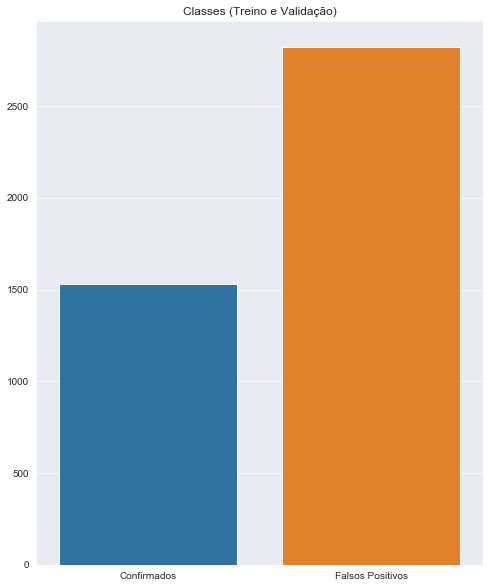

Confirmados: 1530
Falsos Positivos: 2822


In [15]:
pyplot.subplots(figsize=(8, 10))
seaborn.barplot(data=pandas.DataFrame({"Confirmados": y_train.sum(), "Falsos Positivos": y_train.size - y_train.sum()}, index=classes)).set_title("Classes (Treino e Validação)")
pyplot.show()
print("Confirmados:", y_train.sum())
print("Falsos Positivos:", y_train.size - y_train.sum())

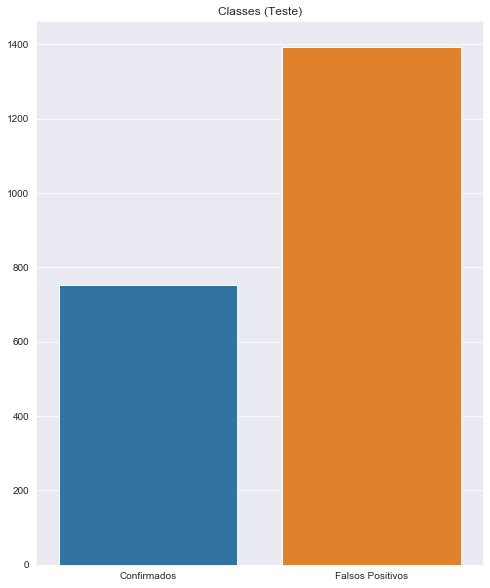

Confirmados: 752
Falsos Positivos: 1393


In [16]:
pyplot.subplots(figsize=(8, 10))
seaborn.barplot(data=pandas.DataFrame({"Confirmados": y_test.sum(), "Falsos Positivos": y_test.size - y_test.sum()}, index=classes)).set_title("Classes (Teste)")
pyplot.show()
print("Confirmados:", y_test.sum())
print("Falsos Positivos:", y_test.size - y_test.sum())

# <i>K-Fold</i>

In [17]:
sets = list(model_selection.KFold(5, shuffle=True).split(x_train))

In [18]:
def cross_validation(model, sets, x, y, p):
    l1 = []
    l2 = []
    for train_set, test_set in sets:
        x_train, y_train = x.iloc[train_set], y.iloc[train_set]
        x_test, y_test = x.iloc[test_set], y.iloc[test_set]
        l = model(x_train, y_train, x_test, y_test, p)
        l1.append(l[0])
        l2.append(l[1])
    return l1, l2

# Perceptron

In [19]:
def linear_perceptron(x_train, y_train, x_test, y_test, p):
    pt = linear_model.Perceptron(penalty=p)
    pt.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, pt.predict(x_train)), metrics.accuracy_score(y_test, pt.predict(x_test)))

In [20]:
pt1_mean, pt1_var, pt2_mean, pt2_var = [], [], [], []
for i in ["l2", "l1", "elasticnet"]:
    a1, a2 = cross_validation(linear_perceptron, sets, x_train, y_train, i)
    pt1_mean.append(numpy.mean(a1))
    pt1_var.append(numpy.var(a1))
    pt2_mean.append(numpy.mean(a2))
    pt2_var.append(numpy.var(a2))

In [21]:
pandas.DataFrame({"Treino (Média)": pt1_mean, "Treino (Variância)": pt1_var, "Validação (Média)": pt2_mean, "Validação (Variância)": pt2_var}, index=["l2", "l1", "elasticnet"])

,Treino (Média),Treino (Variância),Validação (Média),Validação (Variância)
l2,0.88264,0.000216,0.886033,0.000233
l1,0.86558,0.001651,0.867192,0.001279
elasticnet,0.88264,0.000216,0.886033,0.000233


In [22]:
pt = linear_model.Perceptron(penalty="l1")
pt.fit(x_train, y_train)
pt_y_pred = pt.predict(x_test)
ac = metrics.accuracy_score(y_test, pt_y_pred)
models_list["Perceptron"] = ac
print("Accurácia:", ac)

Accurácia: 0.8923076923076924


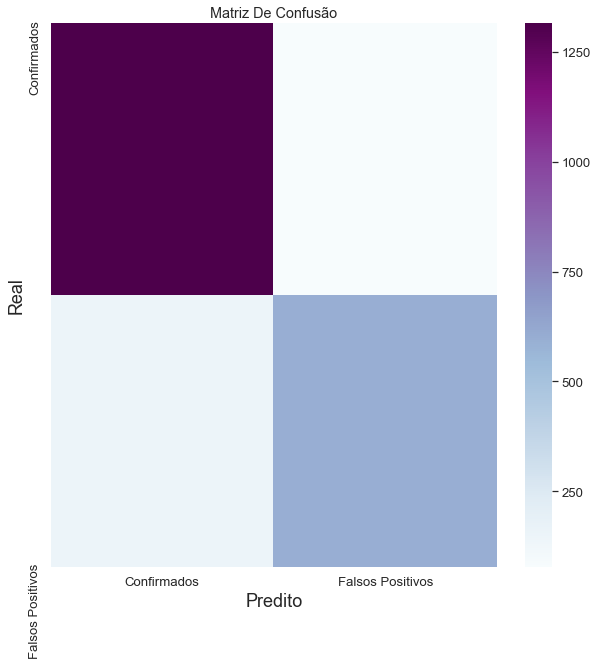

In [23]:
cm = metrics.confusion_matrix(y_test, pt_y_pred)
pyplot.figure(figsize=(10, 10))
seaborn.set(font_scale=1.2)
seaborn.heatmap(pandas.DataFrame(cm, index=classes, columns=classes), annot=False, cmap="BuPu").set_title("Matriz De Confusão")
pyplot.xlabel("Predito", fontsize=18)
pyplot.ylabel("Real", fontsize=18)
pyplot.show()

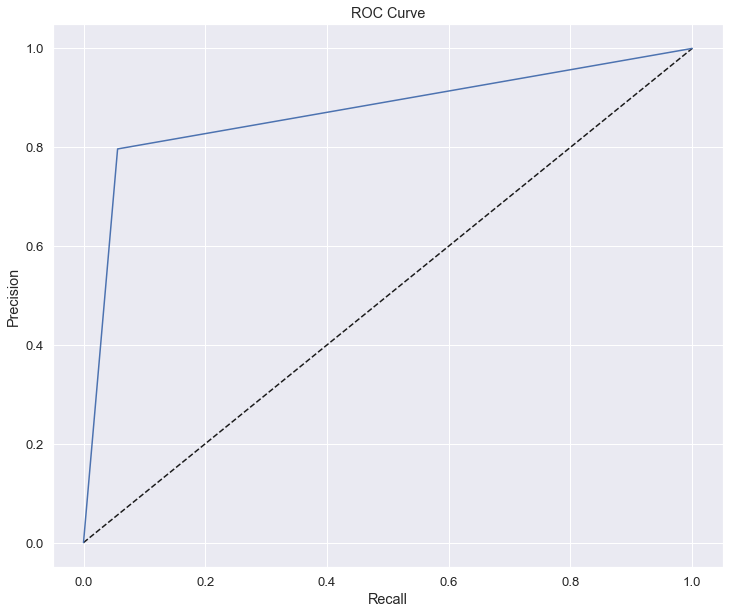

AUC Score: 0.8702741480961035


In [24]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pt_y_pred)
pyplot.subplots(figsize=(12, 10))
pyplot.plot([0,1], [0, 1], "k--")
pyplot.plot(fpr, tpr)
pyplot.xlabel("Recall")
pyplot.ylabel("Precision")
pyplot.title("ROC Curve")
pyplot.show()
auc = metrics.auc(fpr, tpr)
auc_list["Perceptron"] = auc
print("AUC Score:", auc)

# <i>Naive Bayes</i>

In [25]:
def gaussian_naive_bayes(x_train, y_train, x_test, y_test, p):
    gnv = naive_bayes.GaussianNB()
    gnv.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, gnv.predict(x_train)), metrics.accuracy_score(y_test, gnv.predict(x_test)))

In [26]:
g1, g2 = cross_validation(gaussian_naive_bayes, sets, x_train, y_train, None)
pandas.DataFrame({"Média": [numpy.mean(g1), numpy.mean(g2)], "Variância": [numpy.var(g1), numpy.var(g2)]}, index=["Treino", "Validação"])

,Média,Variância
Treino,0.746611,0.000092
Validação,0.745860,0.000172


In [27]:
gnv = naive_bayes.GaussianNB()
gnv.fit(x_train, y_train)
gnv_y_pred = gnv.predict(x_test)
ac = metrics.accuracy_score(y_test, gnv_y_pred)
models_list["Naive Bayes"] = ac
print("Acurácia:", ac)

Acurácia: 0.7365967365967366


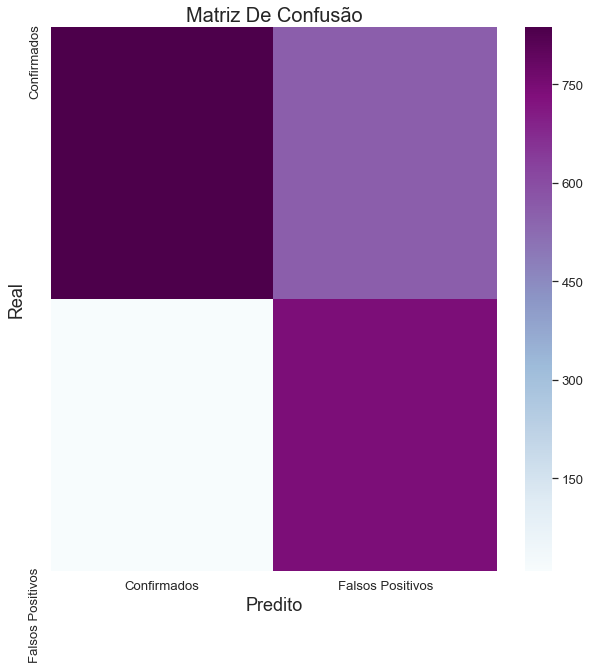

In [28]:
cm = metrics.confusion_matrix(y_test, gnv_y_pred)
pyplot.figure(figsize=(10, 10))
seaborn.set(font_scale=1.2)
seaborn.heatmap(pandas.DataFrame(cm, index=classes, columns=classes), annot=False, cmap="BuPu").set_title("Matriz De Confusão", fontsize=20)
pyplot.xlabel("Predito", fontsize=18)
pyplot.ylabel("Real", fontsize=18)
pyplot.show()

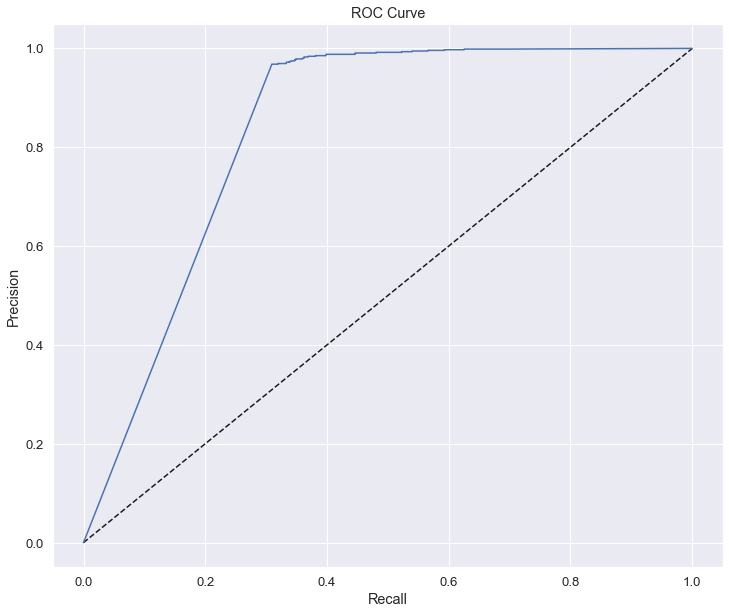

AUC Score: 0.8363932122619175


In [30]:
fpr, tpr, threshold = metrics.roc_curve(y_test, gnv.predict_proba(x_test)[:, 1])
pyplot.subplots(figsize=(12, 10))
pyplot.plot([0,1], [0, 1], "k--")
pyplot.plot(fpr, tpr)
pyplot.xlabel("Recall")
pyplot.ylabel("Precision")
pyplot.title("ROC Curve")
pyplot.show()
auc = metrics.auc(fpr, tpr)
auc_list["Naive Bayes"] = auc
print("AUC Score:", auc)

# Regressão Logística

In [31]:
def logistic_regression(x_train, y_train, x_test, y_test, p):
    lr = linear_model.LogisticRegression(solver=p, max_iter=1000, n_jobs=4)
    lr.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, lr.predict(x_train)), metrics.accuracy_score(y_test, lr.predict(x_test)))

In [32]:
lr1_mean, lr1_var, lr2_mean, lr2_var = [], [], [], []
for i in ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]:
    a1, a2 = cross_validation(logistic_regression, sets, x_train, y_train, i)
    lr1_mean.append(numpy.mean(a1))
    lr1_var.append(numpy.var(a1))
    lr2_mean.append(numpy.mean(a2))
    lr2_var.append(numpy.var(a2))

c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does 

In [35]:
pandas.DataFrame({"Treino (Média)": lr1_mean, "Treino (Variância)": lr1_var, "Validação (Média)": lr2_mean, "Validação (Variância)": lr2_var}, index=["newton-cg", "lbfgs", "liblinear", "sag", "saga"])

,Treino (Média),Treino (Variância),Validação (Média),Validação (Variância)
newton-cg,0.919405,0.000007,0.913606,0.000056
lbfgs,0.919405,0.000007,0.913606,0.000056
liblinear,0.919118,0.000006,0.912227,0.000070
sag,0.918026,0.000005,0.912458,0.000086
saga,0.913431,0.000006,0.908782,0.000084


In [36]:
lr = linear_model.LogisticRegression(solver="newton-cg", max_iter=1000)
lr.fit(x_train, y_train)
lr_y_pred = lr.predict(x_test)
ac = metrics.accuracy_score(y_test, lr_y_pred)
models_list["Regressão Logística"] = ac
print("Accurácia:", ac)

Accurácia: 0.9226107226107226


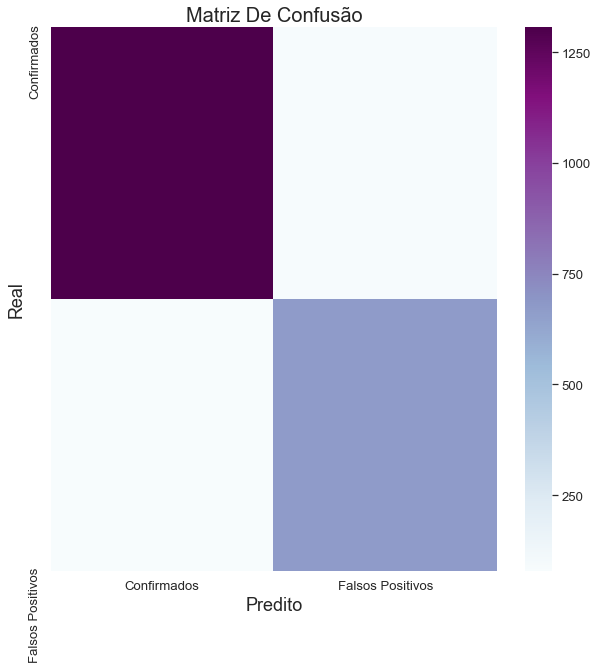

In [37]:
cm = metrics.confusion_matrix(y_test, lr_y_pred)
pyplot.figure(figsize=(10, 10))
seaborn.set(font_scale=1.2)
seaborn.heatmap(pandas.DataFrame(cm, index=classes, columns=classes), annot=False, cmap="BuPu").set_title("Matriz De Confusão", fontsize=20)
pyplot.xlabel("Predito", fontsize=18)
pyplot.ylabel("Real", fontsize=18)
pyplot.show()

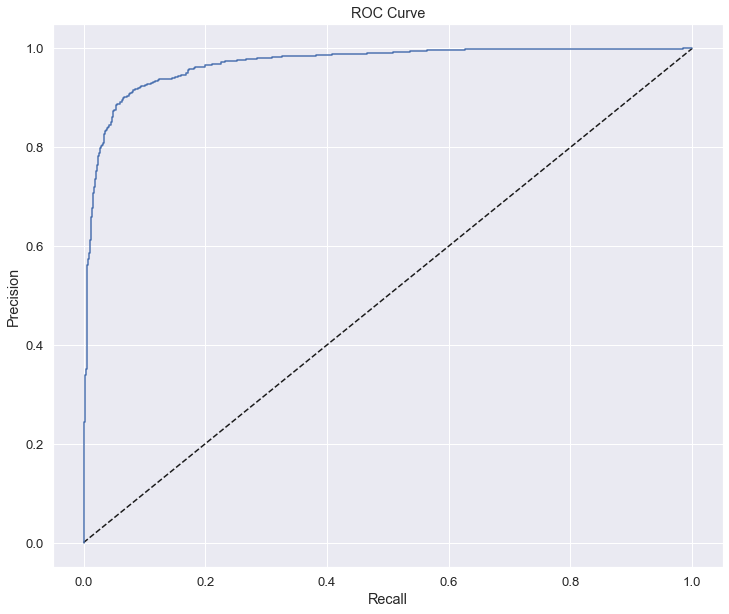

AUC Score: 0.9685690992958715


In [38]:
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict_proba(x_test)[:, 1])
pyplot.subplots(figsize=(12, 10))
pyplot.plot([0,1], [0, 1], "k--")
pyplot.plot(fpr, tpr)
pyplot.xlabel("Recall")
pyplot.ylabel("Precision")
pyplot.title("ROC Curve")
pyplot.show()
auc = metrics.auc(fpr, tpr)
auc_list["Regressão Logística"] = auc
print("AUC Score:", auc)

# Árvore De Decisão

In [39]:
def decision_tree(x_train, y_train, x_test, y_test, p):
    t = tree.DecisionTreeClassifier(max_depth=p)
    t.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, t.predict(x_train)), metrics.accuracy_score(y_test, t.predict(x_test)))

In [40]:
t1_mean, t1_var, t2_mean, t2_var = [], [], [], []
for i in range(1, 31):
    a1, a2 = cross_validation(decision_tree, sets, x_train, y_train, i)
    t1_mean.append(numpy.mean(a1))
    t1_var.append(numpy.var(a1))
    t2_mean.append(numpy.mean(a2))
    t2_var.append(numpy.var(a2))

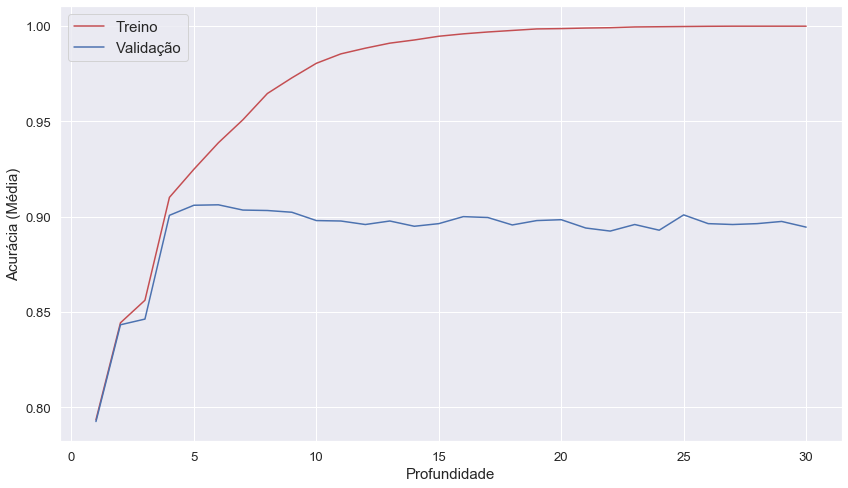

In [41]:
pyplot.subplots(figsize=(14, 8))
pyplot.xlabel("Profundidade", fontsize=15)
pyplot.ylabel("Acurácia (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 31, 1), t1_mean, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 31, 1), t2_mean, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

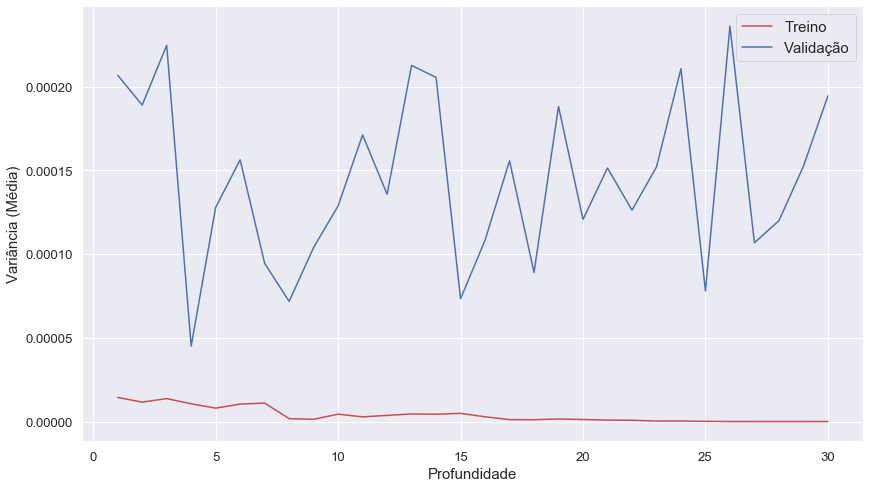

In [42]:
pyplot.subplots(figsize=(14, 8))
pyplot.xlabel("Profundidade", fontsize=15)
pyplot.ylabel("Variância (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 31, 1), t1_var, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 31, 1), t2_var, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

In [43]:
t = tree.DecisionTreeClassifier(max_depth=8)
t.fit(x_train, y_train)
t_y_pred = t.predict(x_test)
ac = metrics.accuracy_score(y_test, t_y_pred)
models_list["Árvove De Decisão"] = ac
print("Acurácia:", ac)

Acurácia: 0.9109557109557109


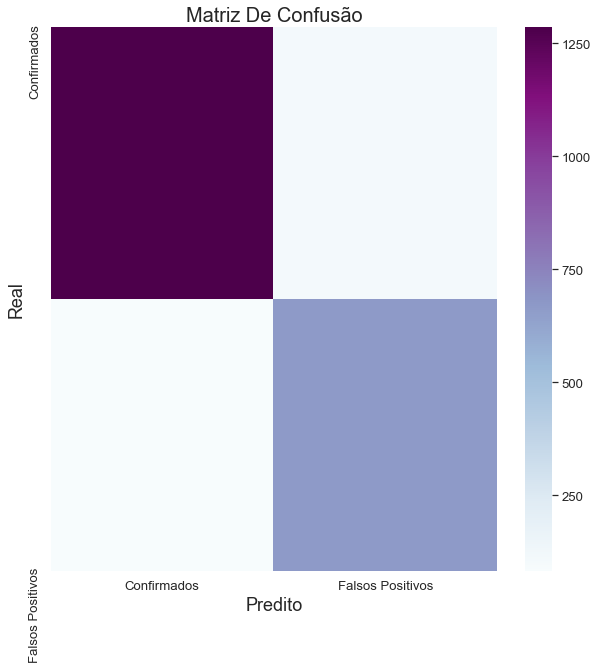

In [44]:
cm = metrics.confusion_matrix(y_test, t_y_pred)
pyplot.figure(figsize=(10, 10))
seaborn.set(font_scale=1.2)
seaborn.heatmap(pandas.DataFrame(cm, index=classes, columns=classes), annot=False, cmap="BuPu").set_title("Matriz De Confusão", fontsize=20)
pyplot.xlabel("Predito", fontsize=18)
pyplot.ylabel("Real", fontsize=18)
pyplot.show()

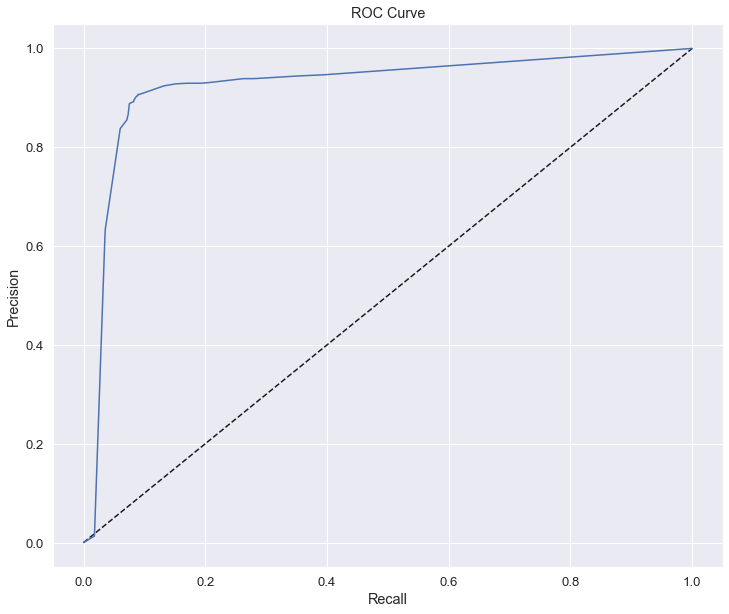

AUC Score: 0.9236541751309739


In [45]:
fpr, tpr, threshold = metrics.roc_curve(y_test, t.predict_proba(x_test)[:, 1])
pyplot.subplots(figsize=(12, 10))
pyplot.plot([0,1], [0, 1], "k--")
pyplot.plot(fpr, tpr)
pyplot.xlabel("Recall")
pyplot.ylabel("Precision")
pyplot.title("ROC Curve")
pyplot.show()
auc = metrics.auc(fpr, tpr)
auc_list["Árvore De Decisão"] = auc
print("AUC Score:", auc)

# <i>Support Vector Machine</i>

In [46]:
def support_vector_machines(x_train, y_train, x_test, y_test, p):
    svm_ = svm.SVC(gamma="scale", kernel=p)
    svm_.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, svm_.predict(x_train)), metrics.accuracy_score(y_test, svm_.predict(x_test)))

In [47]:
s1_mean, s1_var, s2_mean, s2_var = [], [], [], []
for i in ["linear", "poly", "rbf", "sigmoid"]:
    a1, a2 = cross_validation(support_vector_machines, sets, x_train, y_train, i)
    s1_mean.append(numpy.mean(a1))
    s1_var.append(numpy.var(a1))
    s2_mean.append(numpy.mean(a2))
    s2_var.append(numpy.var(a2))

In [48]:
pandas.DataFrame({"Treino (Média)": s1_mean, "Treino (Variância)": s1_var, "Validação (Média)": s2_mean, "Validação (Variância)": s2_var}, index=["Linear", "Sigmóide", "Polinomial", "RBF"])

,Treino (Média),Treino (Variância),Validação (Média),Validação (Variância)
Linear,0.922622,0.000003,0.918433,0.000082
Sigmóide,0.784639,0.000067,0.779191,0.000680
Polinomial,0.920956,0.000007,0.910852,0.000145
RBF,0.847600,0.000162,0.851564,0.000214


In [50]:
svm_ = svm.SVC(gamma="scale", kernel="linear", probability=True)
svm_.fit(x_train, y_train)
svm_y_pred = svm_.predict(x_test)
ac = metrics.accuracy_score(y_test, svm_y_pred)
models_list["SVM"] = ac
print("Acurácia:", ac)

Acurácia: 0.924941724941725


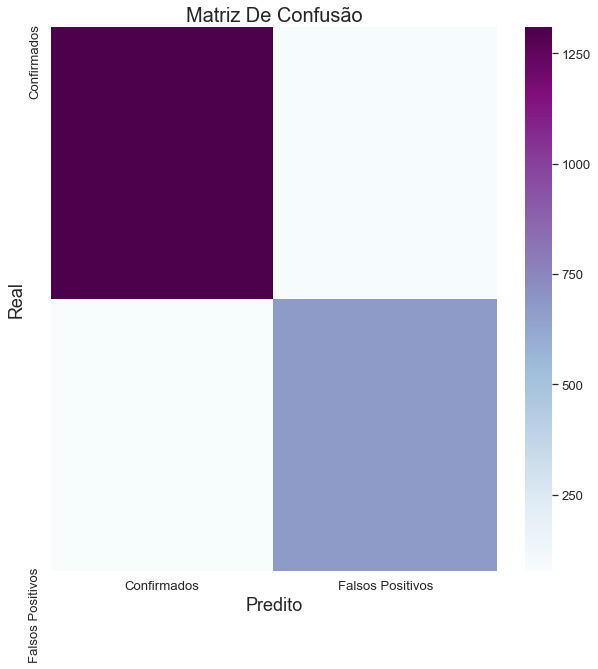

In [51]:
cm = metrics.confusion_matrix(y_test, svm_y_pred)
pyplot.figure(figsize=(10, 10))
seaborn.set(font_scale=1.2)
seaborn.heatmap(pandas.DataFrame(cm, index=classes, columns=classes), annot=False, cmap="BuPu").set_title("Matriz De Confusão", fontsize=20)
pyplot.xlabel("Predito", fontsize=18)
pyplot.ylabel("Real", fontsize=18)
pyplot.show()

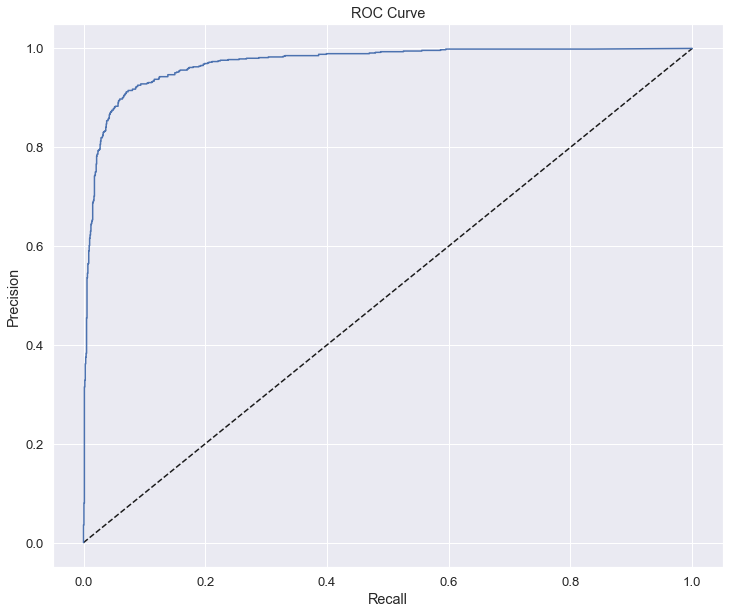

AUC Score: 0.9705423011715111


In [52]:
fpr, tpr, threshold = metrics.roc_curve(y_test, svm_.predict_proba(x_test)[:, 1])
pyplot.subplots(figsize=(12, 10))
pyplot.plot([0,1], [0, 1], "k--")
pyplot.plot(fpr, tpr)
pyplot.xlabel("Recall")
pyplot.ylabel("Precision")
pyplot.title("ROC Curve")
pyplot.show()
auc = metrics.auc(fpr, tpr)
auc_list["SVM"] = auc
print("AUC Score:", auc)

# <i>k-Nearest Neighbours</i>

In [53]:
def k_nearest_neighbours(x_train, y_train, x_test, y_test, p):
    knn = neighbors.KNeighborsClassifier(n_neighbors=p, n_jobs=4)
    knn.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, knn.predict(x_train)), metrics.accuracy_score(y_test, knn.predict(x_test)))

In [54]:
k1_mean, k1_var, k2_mean, k2_var = [], [], [], []
for i in range(1, 51):
    a1, a2 = cross_validation(k_nearest_neighbours, sets, x_train, y_train, i)
    k1_mean.append(numpy.mean(a1))
    k1_var.append(numpy.var(a1))
    k2_mean.append(numpy.mean(a2))
    k2_var.append(numpy.var(a2))

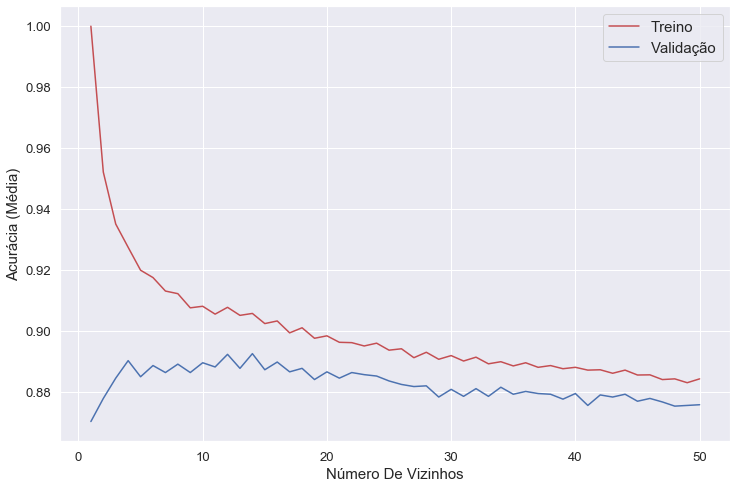

In [55]:
pyplot.subplots(figsize=(12, 8))
pyplot.xlabel("Número De Vizinhos", fontsize=15)
pyplot.ylabel("Acurácia (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 51, 1), k1_mean, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), k2_mean, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

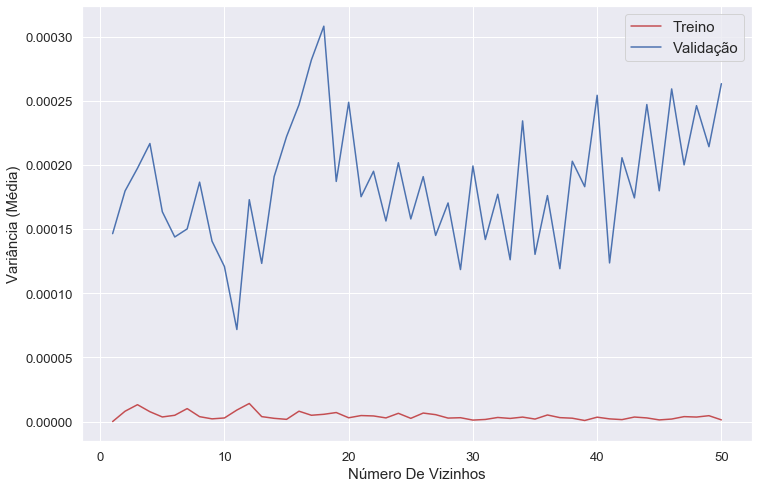

In [56]:
pyplot.subplots(figsize=(12, 8))
pyplot.xlabel("Número De Vizinhos", fontsize=15)
pyplot.ylabel("Variância (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 51, 1), k1_var, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), k2_var, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

In [57]:
knn = neighbors.KNeighborsClassifier(n_neighbors=12, n_jobs=4)
knn.fit(x_train, y_train)
knn_y_pred = knn.predict(x_test)
ac = metrics.accuracy_score(y_test, knn_y_pred)
models_list["k-NN"] = ac
print("Acurácia:", ac)

Acurácia: 0.8955710955710956


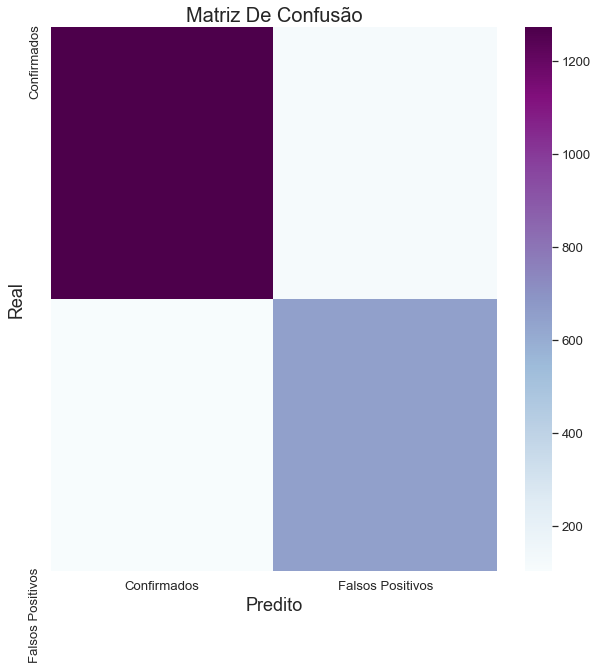

In [58]:
cm = metrics.confusion_matrix(y_test, knn_y_pred)
pyplot.figure(figsize=(10, 10))
seaborn.set(font_scale=1.2)
seaborn.heatmap(pandas.DataFrame(cm, index=classes, columns=classes), annot=False, cmap="BuPu").set_title("Matriz De Confusão", fontsize=20)
pyplot.xlabel("Predito", fontsize=18)
pyplot.ylabel("Real", fontsize=18)
pyplot.show()

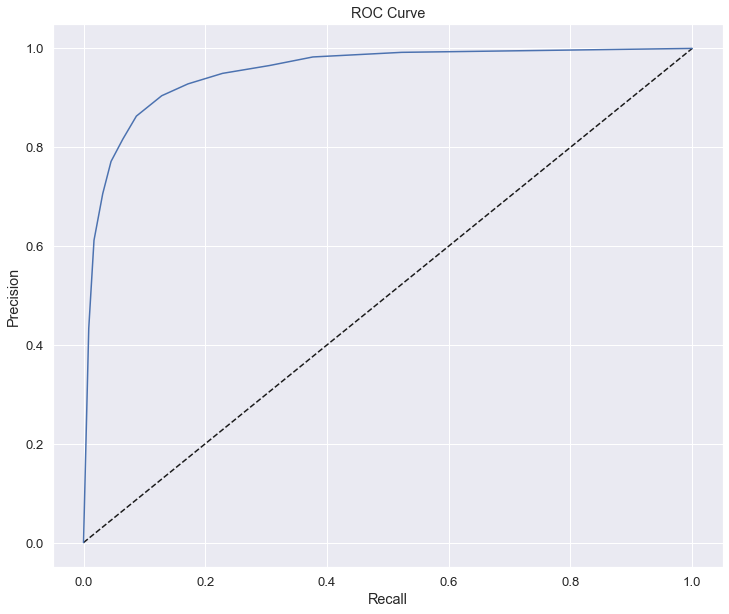

AUC Score: 0.9523080829680316


In [59]:
fpr, tpr, threshold = metrics.roc_curve(y_test, knn.predict_proba(x_test)[:, 1])
pyplot.subplots(figsize=(12, 10))
pyplot.plot([0,1], [0, 1], "k--")
pyplot.plot(fpr, tpr)
pyplot.xlabel("Recall")
pyplot.ylabel("Precision")
pyplot.title("ROC Curve")
pyplot.show()
auc = metrics.auc(fpr, tpr)
auc_list["k-NN"] = auc
print("AUC Score:", auc)

# <i>Adaboost</i>

In [60]:
def adaboost(x_train, y_train, x_test, y_test, p):
    ab = ensemble.AdaBoostClassifier(n_estimators=p)
    ab.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, ab.predict(x_train)), metrics.accuracy_score(y_test, ab.predict(x_test)))

In [61]:
ab1_mean, ab1_var, ab2_mean, ab2_var = [], [], [], []
for i in range(1, 51):
    a1, a2 = cross_validation(adaboost, sets, x_train, y_train, i)
    ab1_mean.append(numpy.mean(a1))
    ab1_var.append(numpy.var(a1))
    ab2_mean.append(numpy.mean(a2))
    ab2_var.append(numpy.var(a2))

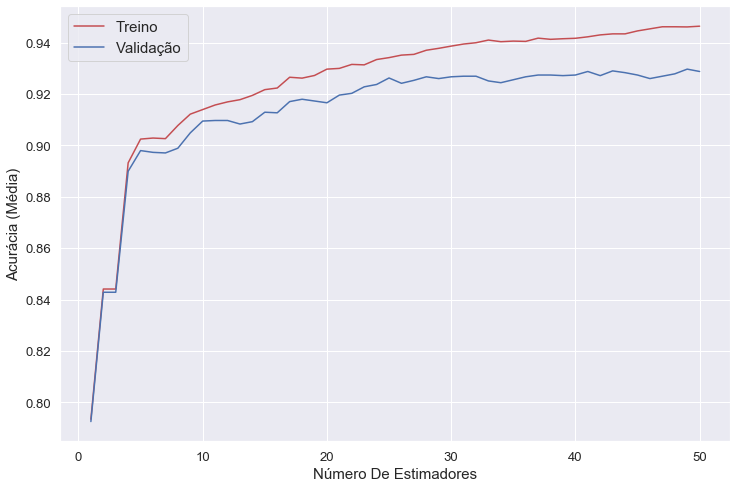

In [62]:
pyplot.subplots(figsize=(12, 8))
pyplot.xlabel("Número De Estimadores", fontsize=15)
pyplot.ylabel("Acurácia (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 51, 1), ab1_mean, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), ab2_mean, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

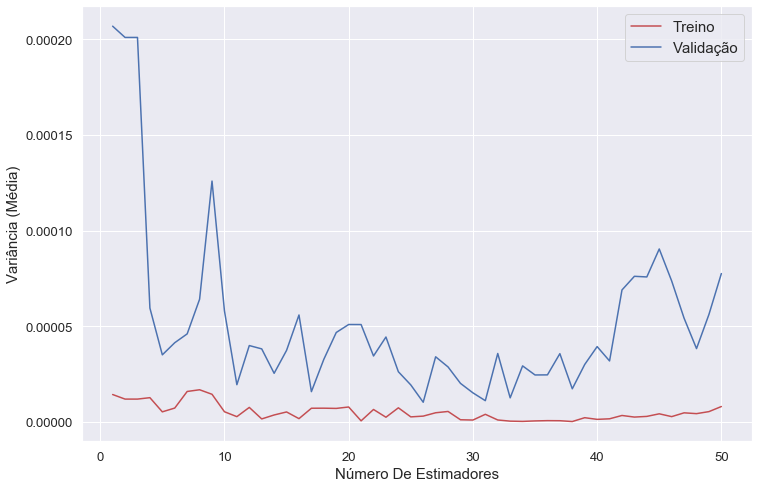

In [63]:
pyplot.subplots(figsize=(12, 8))
pyplot.xlabel("Número De Estimadores", fontsize=15)
pyplot.ylabel("Variância (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 51, 1), ab1_var, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), ab2_var, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

In [64]:
ab = ensemble.AdaBoostClassifier(n_estimators=23)
ab.fit(x_train, y_train)
ab_y_pred = ab.predict(x_test)
ac = metrics.accuracy_score(y_test, ab_y_pred)
models_list["Adaboost"] = ac
print("Acurácia:", ac)

Acurácia: 0.9230769230769231


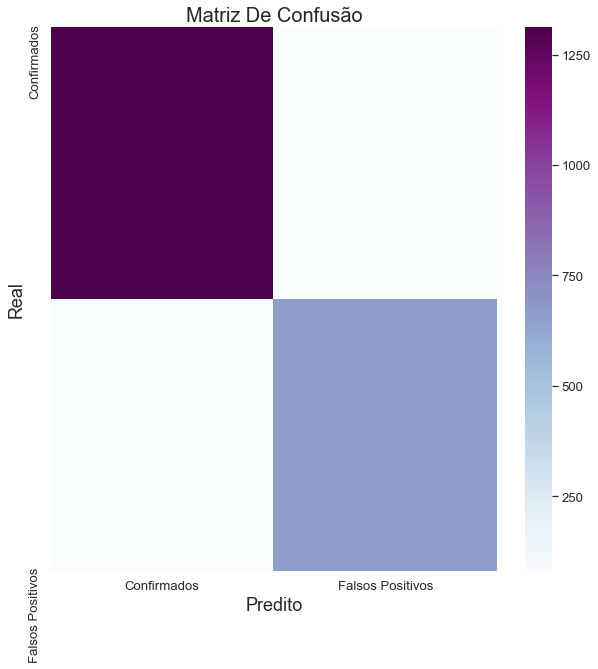

In [65]:
cm = metrics.confusion_matrix(y_test, ab_y_pred)
pyplot.figure(figsize=(10, 10))
seaborn.set(font_scale=1.2)
seaborn.heatmap(pandas.DataFrame(cm, index=classes, columns=classes), annot=False, cmap="BuPu").set_title("Matriz De Confusão", fontsize=20)
pyplot.xlabel("Predito", fontsize=18)
pyplot.ylabel("Real", fontsize=18)
pyplot.show()

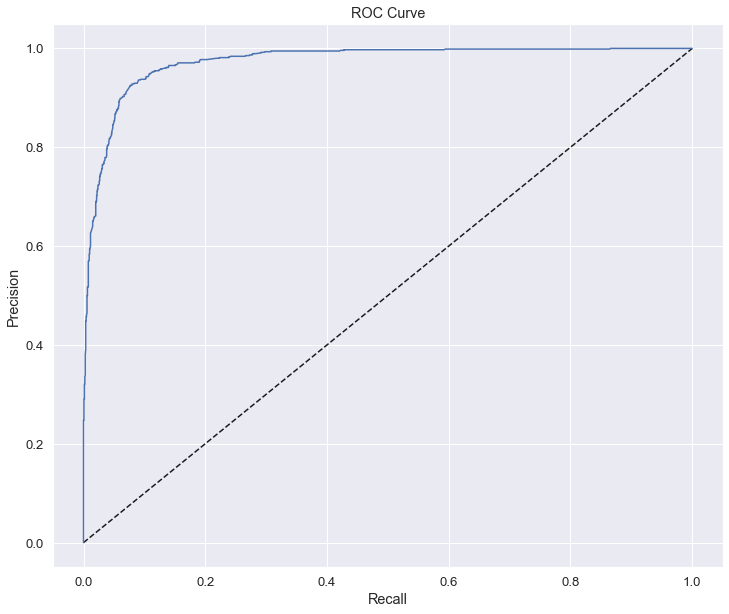

AUC Score: 0.9730343396312872


In [66]:
fpr, tpr, threshold = metrics.roc_curve(y_test, ab.predict_proba(x_test)[:, 1])
pyplot.subplots(figsize=(12, 10))
pyplot.plot([0,1], [0, 1], "k--")
pyplot.plot(fpr, tpr)
pyplot.xlabel("Recall")
pyplot.ylabel("Precision")
pyplot.title("ROC Curve")
pyplot.show()
auc = metrics.auc(fpr, tpr)
auc_list["Adaboost"] = auc
print("AUC Score:", auc)

# <i>Bagging</i>

In [67]:
def bagging(x_train, y_train, x_test, y_test, p):
    bgg = ensemble.BaggingClassifier(n_jobs=4, n_estimators=p)
    bgg.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, bgg.predict(x_train)), metrics.accuracy_score(y_test, bgg.predict(x_test)))

In [68]:
bgg1_mean, bgg1_var, bgg2_mean, bgg2_var = [], [], [], []
for i in range(1, 51):
    a1, a2 = cross_validation(bagging, sets, x_train, y_train, i)
    bgg1_mean.append(numpy.mean(a1))
    bgg1_var.append(numpy.var(a1))
    bgg2_mean.append(numpy.mean(a2))
    bgg2_var.append(numpy.var(a2))

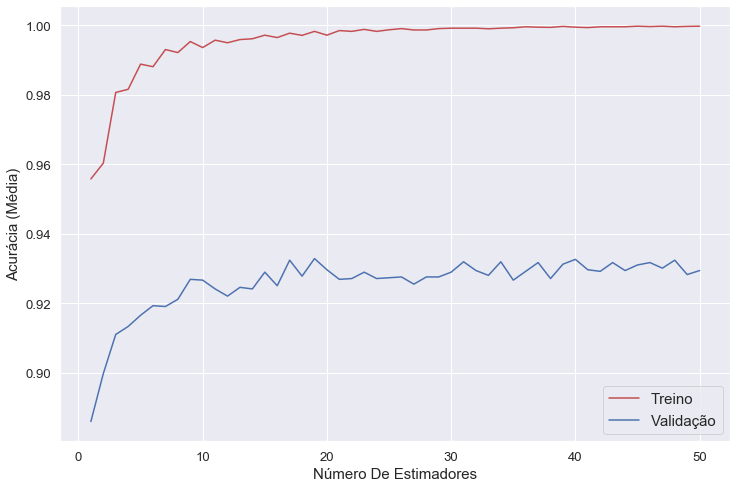

In [69]:
pyplot.subplots(figsize=(12, 8))
pyplot.xlabel("Número De Estimadores", fontsize=15)
pyplot.ylabel("Acurácia (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 51, 1), bgg1_mean, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), bgg2_mean, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

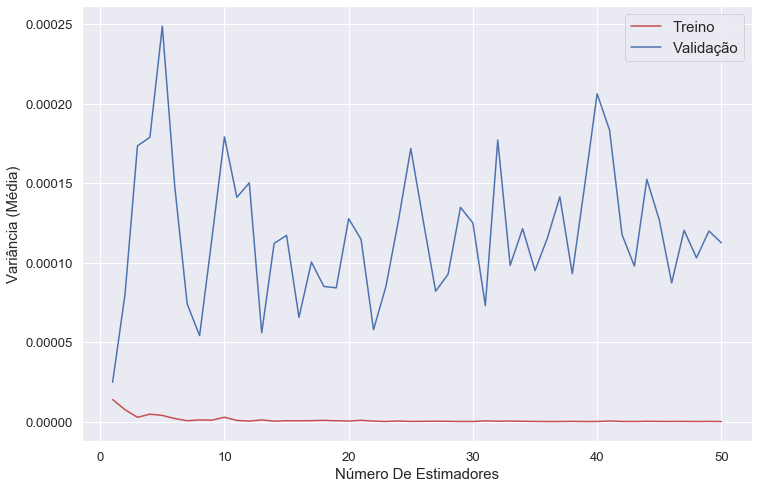

In [70]:
pyplot.subplots(figsize=(12, 8))
pyplot.xlabel("Número De Estimadores", fontsize=15)
pyplot.ylabel("Variância (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 51, 1), bgg1_var, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), bgg2_var, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

In [71]:
bgg = ensemble.BaggingClassifier(n_estimators=10)
bgg.fit(x_train, y_train)
bgg_y_pred = bgg.predict(x_test)
ac = metrics.accuracy_score(y_test, bgg_y_pred)
models_list["Bagging"] = ac
print("Acurácia:", ac)

Acurácia: 0.9268065268065268


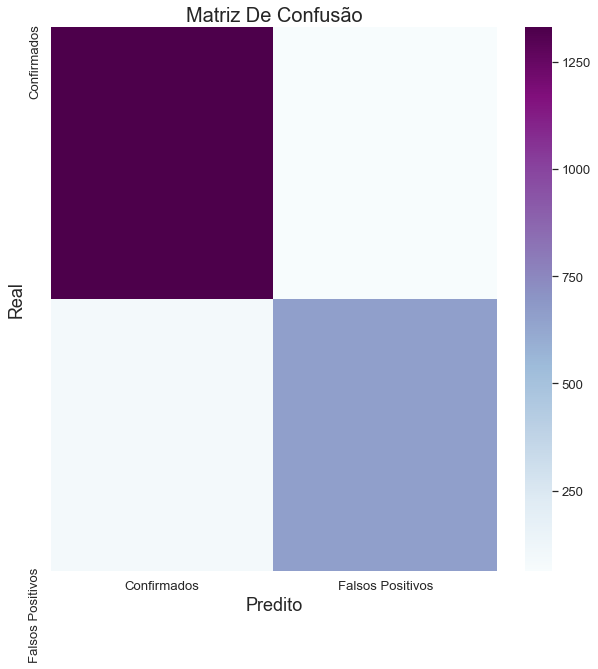

In [72]:
cm = metrics.confusion_matrix(y_test, bgg_y_pred)
pyplot.figure(figsize=(10, 10))
seaborn.set(font_scale=1.2)
seaborn.heatmap(pandas.DataFrame(cm, index=classes, columns=classes), annot=False, cmap="BuPu").set_title("Matriz De Confusão", fontsize=20)
pyplot.xlabel("Predito", fontsize=18)
pyplot.ylabel("Real", fontsize=18)
pyplot.show()

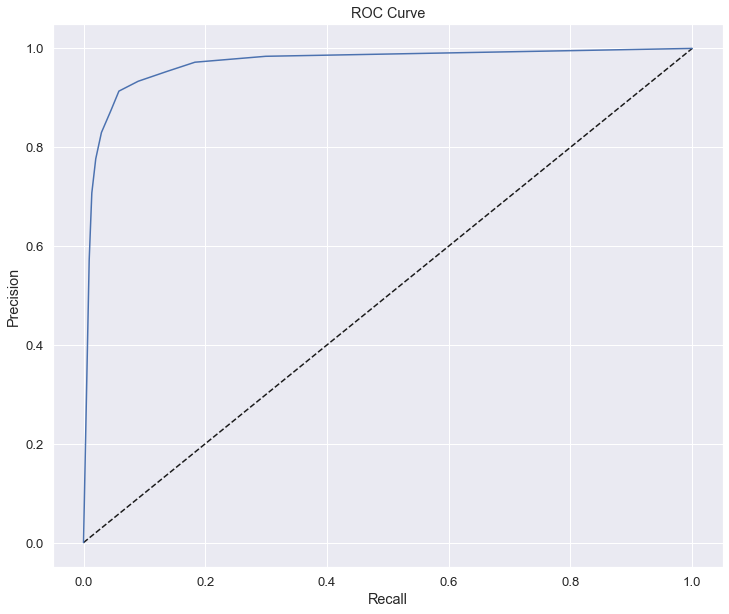

AUC Score: 0.9696373203403034


In [73]:
fpr, tpr, threshold = metrics.roc_curve(y_test, bgg.predict_proba(x_test)[:, 1])
pyplot.subplots(figsize=(12, 10))
pyplot.plot([0,1], [0, 1], "k--")
pyplot.plot(fpr, tpr)
pyplot.xlabel("Recall")
pyplot.ylabel("Precision")
pyplot.title("ROC Curve")
pyplot.show()
print("AUC Score:", metrics.auc(fpr, tpr))

# <i>Random Forest</i>

In [74]:
def random_forest(x_train, y_train, x_test, y_test, p):
    rf = ensemble.RandomForestClassifier(max_depth=5, n_estimators=p)
    rf.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, rf.predict(x_train)), metrics.accuracy_score(y_test, rf.predict(x_test)))

In [75]:
rf1_mean, rf1_var, rf2_mean, rf2_var = [], [], [], []
for i in range(1, 51):
    a1, a2 = cross_validation(random_forest, sets, x_train, y_train, i)
    rf1_mean.append(numpy.mean(a1))
    rf1_var.append(numpy.var(a1))
    rf2_mean.append(numpy.mean(a2))
    rf2_var.append(numpy.var(a2))

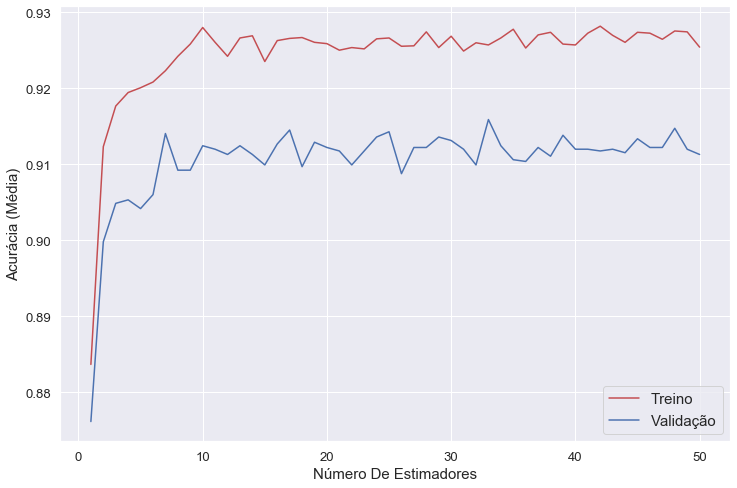

In [76]:
pyplot.subplots(figsize=(12, 8))
pyplot.xlabel("Número De Estimadores", fontsize=15)
pyplot.ylabel("Acurácia (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 51, 1), rf1_mean, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), rf2_mean, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

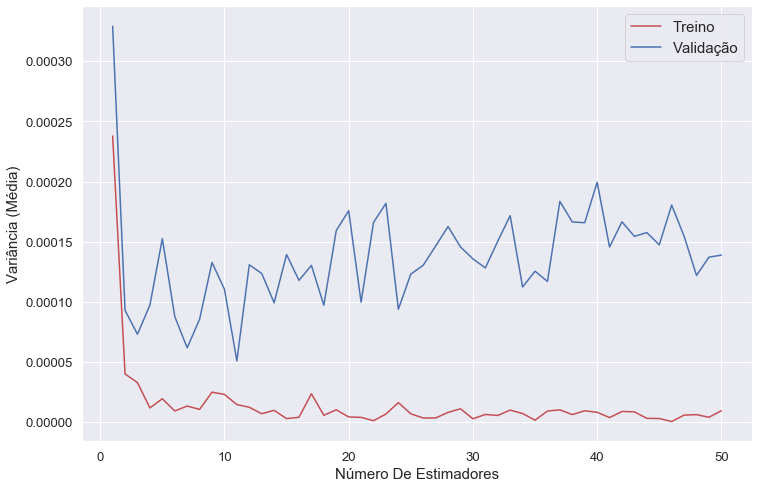

In [77]:
pyplot.subplots(figsize=(12, 8))
pyplot.xlabel("Número De Estimadores", fontsize=15)
pyplot.ylabel("Variância (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 51, 1), rf1_var, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), rf2_var, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

In [78]:
rf = ensemble.RandomForestClassifier(max_depth=5, n_estimators=24)
rf.fit(x_train, y_train)
rf_y_pred = rf.predict(x_test)
ac = metrics.accuracy_score(y_test, rf_y_pred)
models_list["Random Forest"] = ac
print("Acurácia:", ac)

Acurácia: 0.916083916083916


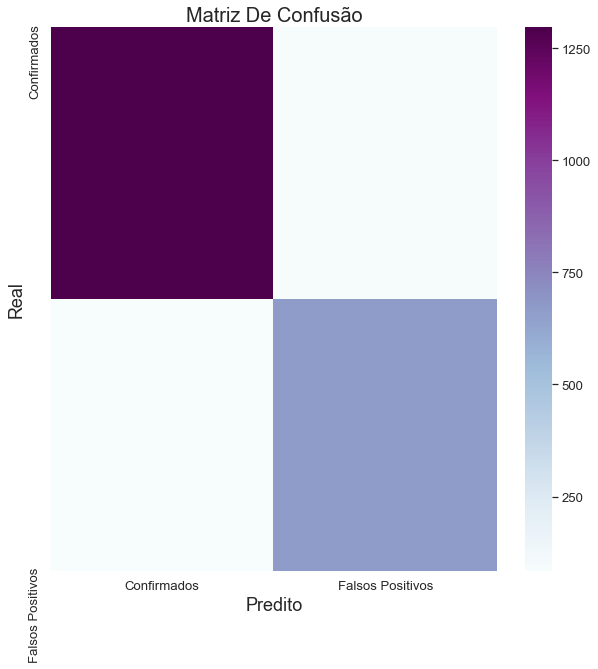

In [79]:
cm = metrics.confusion_matrix(y_test, rf_y_pred)
pyplot.figure(figsize=(10, 10))
seaborn.set(font_scale=1.2)
seaborn.heatmap(pandas.DataFrame(cm, index=classes, columns=classes), annot=False, cmap="BuPu").set_title("Matriz De Confusão", fontsize=20)
pyplot.xlabel("Predito", fontsize=18)
pyplot.ylabel("Real", fontsize=18)
pyplot.show()

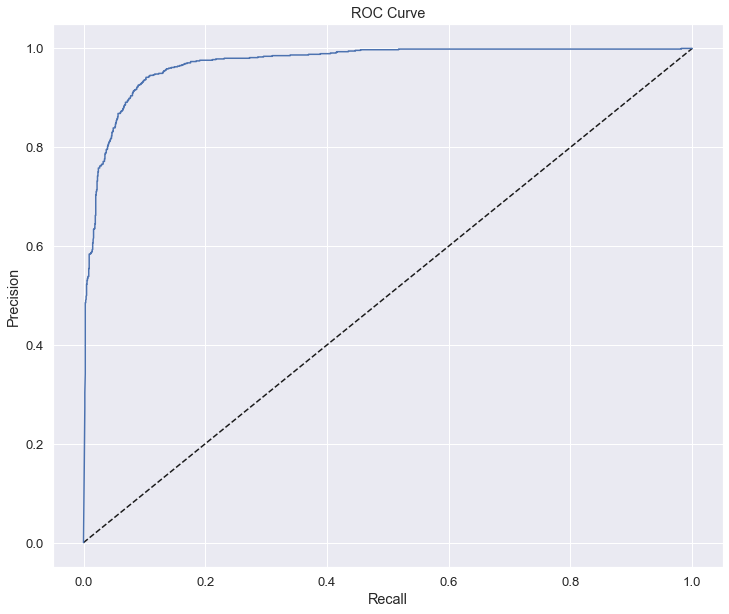

AUC Score: 0.9701365871912756


In [80]:
fpr, tpr, threshold = metrics.roc_curve(y_test, rf.predict_proba(x_test)[:, 1])
pyplot.subplots(figsize=(12, 10))
pyplot.plot([0,1], [0, 1], "k--")
pyplot.plot(fpr, tpr)
pyplot.xlabel("Recall")
pyplot.ylabel("Precision")
pyplot.title("ROC Curve")
pyplot.show()
auc = metrics.auc(fpr, tpr)
print("AUC Score:", auc)

# <i>Gradient Tree Boosting</i>

In [81]:
def gradient_tree_boosting(x_train, y_train, x_test, y_test, p):
    gtb = ensemble.GradientBoostingClassifier(n_estimators=p)
    gtb.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, gtb.predict(x_train)), metrics.accuracy_score(y_test, gtb.predict(x_test)))

In [82]:
gtb1_mean, gtb1_var, gtb2_mean, gtb2_var = [], [], [], []
for i in range(1, 51):
    a1, a2 = cross_validation(gradient_tree_boosting, sets, x_train, y_train, i)
    gtb1_mean.append(numpy.mean(a1))
    gtb1_var.append(numpy.var(a1))
    gtb2_mean.append(numpy.mean(a2))
    gtb2_var.append(numpy.var(a2))

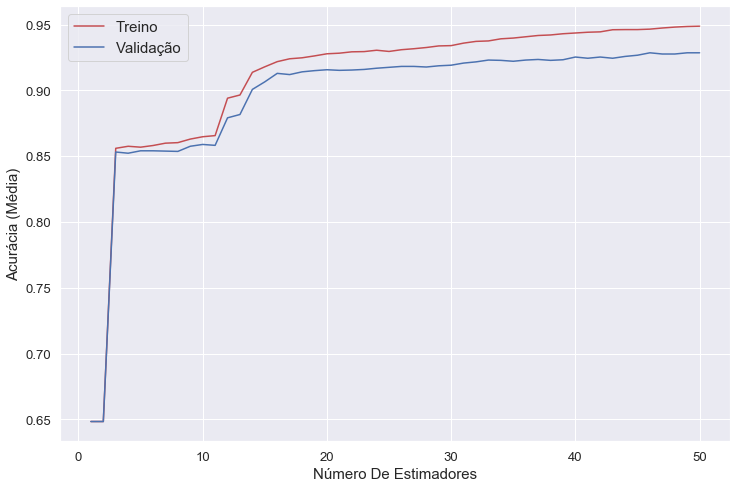

In [83]:
pyplot.subplots(figsize=(12, 8))
pyplot.xlabel("Número De Estimadores", fontsize=15)
pyplot.ylabel("Acurácia (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 51, 1), gtb1_mean, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), gtb2_mean, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

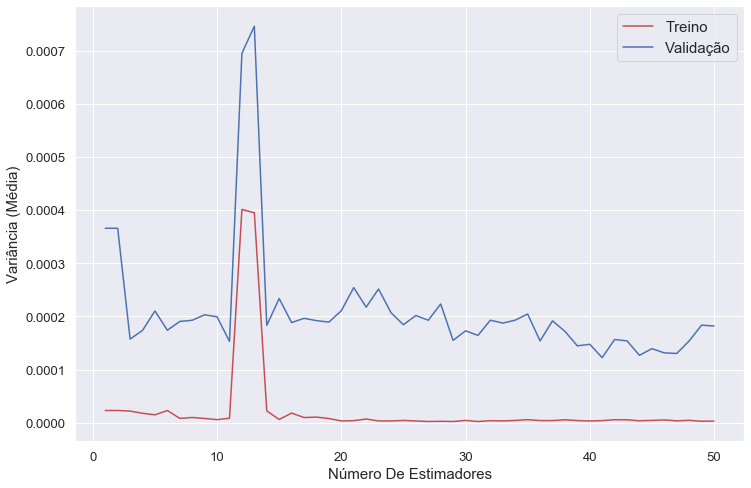

In [84]:
pyplot.subplots(figsize=(12, 8))
pyplot.xlabel("Número De Estimadores", fontsize=15)
pyplot.ylabel("Variância (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 51, 1), gtb1_var, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), gtb2_var, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

In [85]:
gtb = ensemble.GradientBoostingClassifier(n_estimators=48)
gtb.fit(x_train, y_train)
gtb_y_pred = gtb.predict(x_test)
ac = metrics.accuracy_score(y_test, gtb_y_pred)
models_list["Gradient Tree Boosting"] = ac
print("Acurácia:", ac)

Acurácia: 0.931002331002331


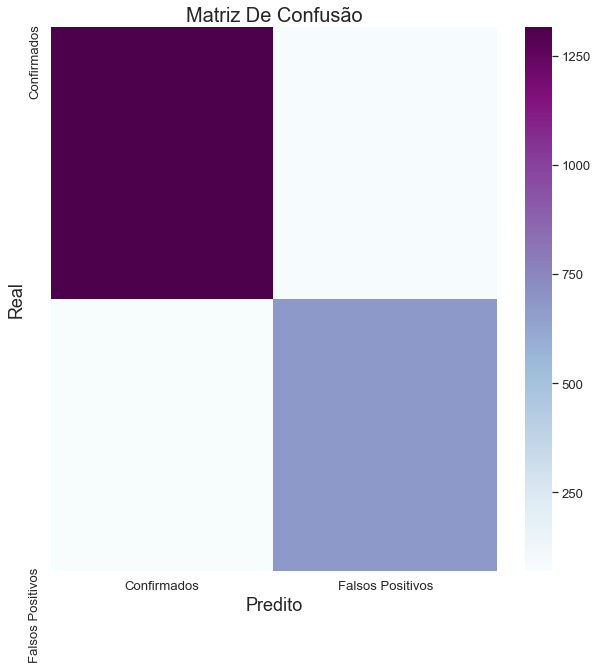

In [86]:
cm = metrics.confusion_matrix(y_test, gtb_y_pred)
pyplot.figure(figsize=(10, 10))
seaborn.set(font_scale=1.2)
seaborn.heatmap(pandas.DataFrame(cm, index=classes, columns=classes), annot=False, cmap="BuPu").set_title("Matriz De Confusão", fontsize=20)
pyplot.xlabel("Predito", fontsize=18)
pyplot.ylabel("Real", fontsize=18)
pyplot.show()

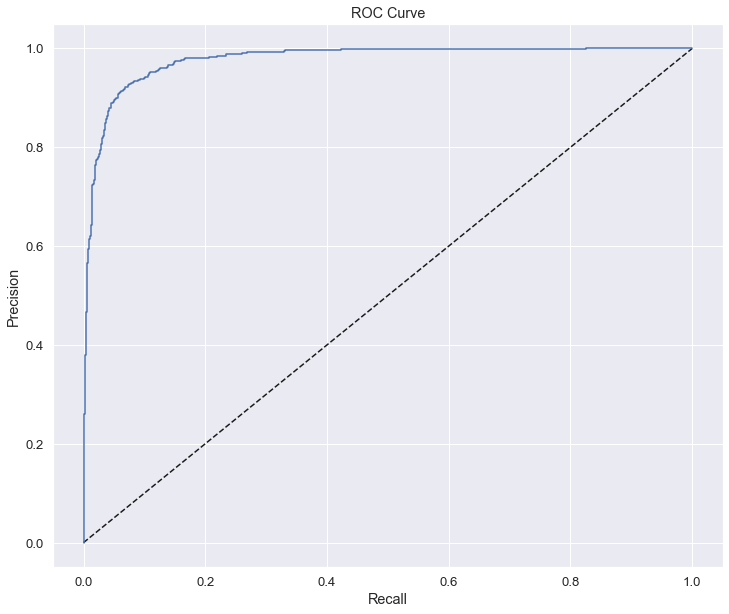

AUC Score: 0.9771826457515541


In [87]:
fpr, tpr, threshold = metrics.roc_curve(y_test, gtb.predict_proba(x_test)[:, 1])
pyplot.subplots(figsize=(12, 10))
pyplot.plot([0,1], [0, 1], "k--")
pyplot.plot(fpr, tpr)
pyplot.xlabel("Recall")
pyplot.ylabel("Precision")
pyplot.title("ROC Curve")
pyplot.show()
auc = metrics.auc(fpr, tpr)
auc_list["Gradient Tree Boosting"] = auc
print("AUC Score:", auc)

# <i>XGBoost</i>

In [88]:
def xgb_tree(x_train, y_train, x_test, y_test, p):
    xgb = xgboost.sklearn.XGBClassifier(n_jobs=4, n_estimators=p)
    xgb.fit(x_train, y_train)
    return (metrics.accuracy_score(y_train, xgb.predict(x_train)), metrics.accuracy_score(y_test, xgb.predict(x_test)))

In [89]:
xgb1_mean, xgb1_var, xgb2_mean, xgb2_var = [], [], [], []
for i in range(1, 51):
    a1, a2 = cross_validation(xgb_tree, sets, x_train, y_train, i)
    xgb1_mean.append(numpy.mean(a1))
    xgb1_var.append(numpy.var(a1))
    xgb2_mean.append(numpy.mean(a2))
    xgb2_var.append(numpy.var(a2))

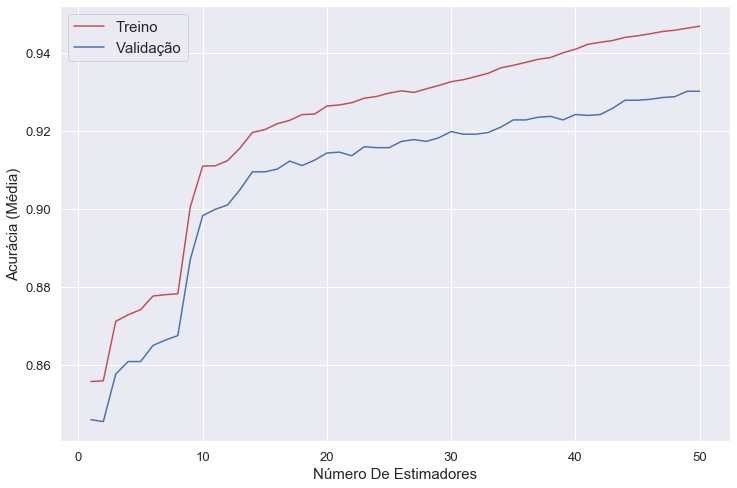

In [90]:
pyplot.subplots(figsize=(12, 8))
pyplot.xlabel("Número De Estimadores", fontsize=15)
pyplot.ylabel("Acurácia (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 51, 1), xgb1_mean, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), xgb2_mean, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

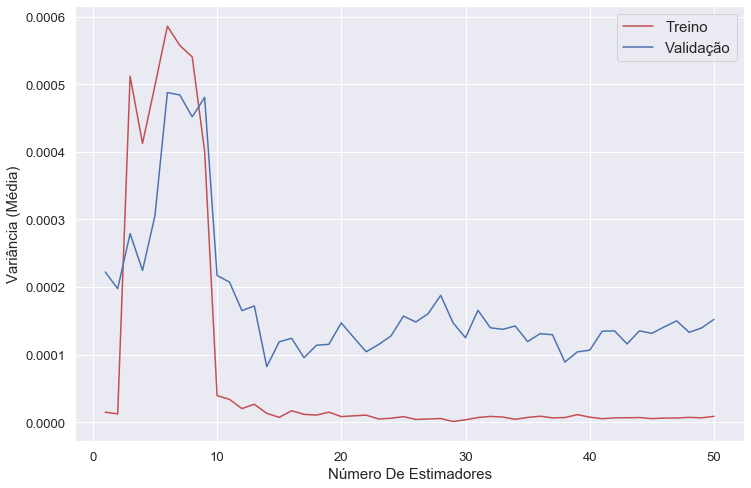

In [91]:
pyplot.subplots(figsize=(12, 8))
pyplot.xlabel("Número De Estimadores", fontsize=15)
pyplot.ylabel("Variância (Média)", fontsize=15)
pyplot.plot(numpy.arange(1, 51, 1), xgb1_var, "r-", label="Treino")
pyplot.plot(numpy.arange(1, 51, 1), xgb2_var, "b-", label="Validação")
pyplot.legend(fontsize=15)
pyplot.show()

In [92]:
xgb = xgboost.sklearn.XGBClassifier(n_jobs=4, n_estimators=43)
xgb.fit(x_train, y_train)
xgb_y_pred = xgb.predict(x_test)
ac = metrics.accuracy_score(y_test, xgb_y_pred)
models_list["XGBoost"] = ac
print("Acurácia:", ac)

Acurácia: 0.9230769230769231


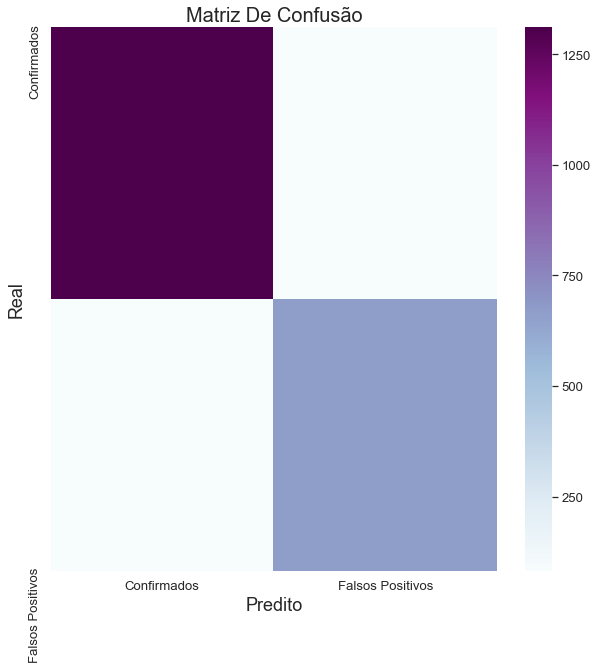

In [93]:
cm = metrics.confusion_matrix(y_test, xgb_y_pred)
pyplot.figure(figsize=(10, 10))
seaborn.set(font_scale=1.2)
seaborn.heatmap(pandas.DataFrame(cm, index=classes, columns=classes), annot=False, cmap="BuPu").set_title("Matriz De Confusão", fontsize=20)
pyplot.xlabel("Predito", fontsize=18)
pyplot.ylabel("Real", fontsize=18)
pyplot.show()

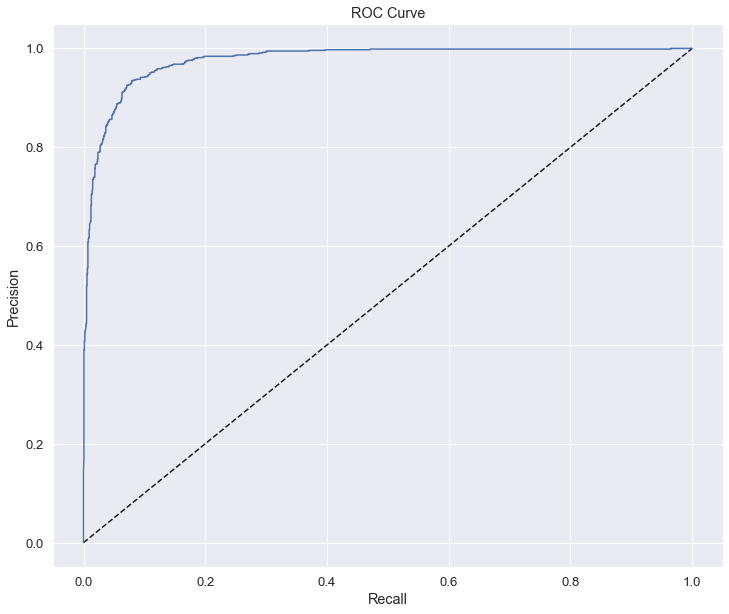

AUC Score: 0.9765521184952116


In [94]:
fpr, tpr, threshold = metrics.roc_curve(y_test, xgb.predict_proba(x_test)[:, 1])
pyplot.subplots(figsize=(12, 10))
pyplot.plot([0,1], [0, 1], "k--")
pyplot.plot(fpr, tpr)
pyplot.xlabel("Recall")
pyplot.ylabel("Precision")
pyplot.title("ROC Curve")
pyplot.show()
auc = metrics.auc(fpr, tpr)
auc_list["XGBoost"] = auc
print("AUC Score:", auc)

# Rede Neural Multicamadas

In [95]:
def create_neural_network():
    net = models.Sequential()
    net.add(layers.Dense(128, activation="softsign", name="Dense0"))
    net.add(layers.Dense(32, activation="softsign", name="Dense1"))
    net.add(layers.Dense(8, activation="softsign", name="Dense2"))
    net.add(layers.Dense(2, activation="softsign", name="Dense3"))
    net.add(layers.Dense(1, activation="sigmoid", name="Output"))
    return net

In [96]:
def neural_network(x_train, y_train, x_test, y_test, p):
    net = create_neural_network()
    net.compile(optimizer=optimizers.Adagrad(lr=0.0253), loss="binary_crossentropy")
    net.fit(x_train.values, y_train.values, epochs=50, batch_size=32, verbose=0)
    return (metrics.accuracy_score(y_train, net.predict_classes(x_train.values)), metrics.accuracy_score(y_test, net.predict_classes(x_test.values)))

In [ ]:
a1, a2 = cross_validation(neural_network, sets, x_train, y_train, None)

In [100]:
pandas.DataFrame({"Média": [numpy.mean(a1), numpy.mean(a2)], "Variância": [numpy.var(a1), numpy.var(a2)]}, index=["Treino", "Validação"])

,Média,Variância
Treino,0.946864,0.000009
Validação,0.930151,0.000152


In [101]:
net = create_neural_network()
net.compile(optimizer=optimizers.Adagrad(lr=0.0253), loss="binary_crossentropy")
net.fit(x_train.values, y_train.values, epochs=50, batch_size=32)

Epoch 1/50
4352/4352 [==============================] - 1s 130us/step - loss: 0.4246
Epoch 2/50
4352/4352 [==============================] - 0s 81us/step - loss: 0.3184
Epoch 3/50
4352/4352 [==============================] - 0s 84us/step - loss: 0.2810
Epoch 4/50
4352/4352 [==============================] - 0s 84us/step - loss: 0.2623
Epoch 5/50
4352/4352 [==============================] - 0s 82us/step - loss: 0.2457
Epoch 6/50
4352/4352 [==============================] - 0s 82us/step - loss: 0.2282
Epoch 7/50
4352/4352 [==============================] - 0s 81us/step - loss: 0.2181
Epoch 8/50
4352/4352 [==============================] - 0s 92us/step - loss: 0.2109
Epoch 9/50
4352/4352 [==============================] - 0s 82us/step - loss: 0.2033
Epoch 10/50
4352/4352 [==============================] - 0s 82us/step - loss: 0.1987
Epoch 11/50
4352/4352 [==============================] - 0s 85us/step - loss: 0.1904
Epoch 12/50
4352/4352 [==============================] - 0s 82us/step - l

In [102]:
net_y_pred = net.predict_classes(x_test.values)
ac = metrics.accuracy_score(y_test, net_y_pred)
models_list["Rede Neural Multicamadas"] = ac
print("Acurácia:", ac)

Acurácia: 0.9393939393939394


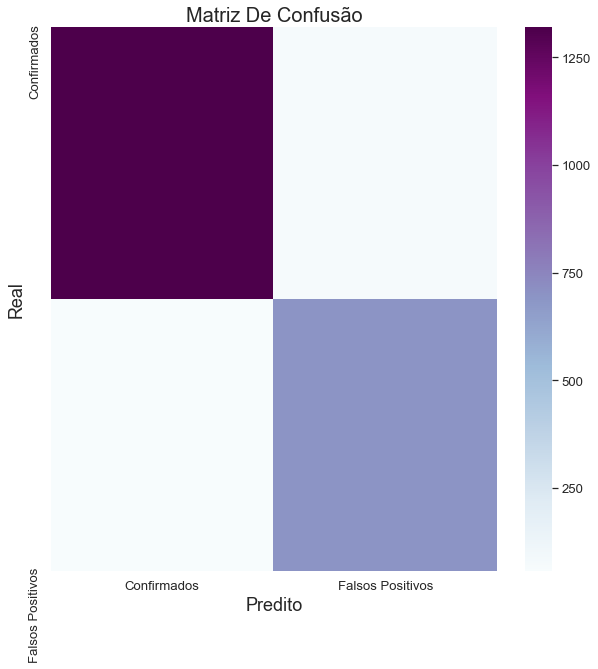

In [103]:
cm = metrics.confusion_matrix(y_test, net_y_pred)
pyplot.figure(figsize=(10, 10))
seaborn.set(font_scale=1.2)
seaborn.heatmap(pandas.DataFrame(cm, index=classes, columns=classes), annot=False, cmap="BuPu").set_title("Matriz De Confusão", fontsize=20)
pyplot.xlabel("Predito", fontsize=18)
pyplot.ylabel("Real", fontsize=18)
pyplot.show()

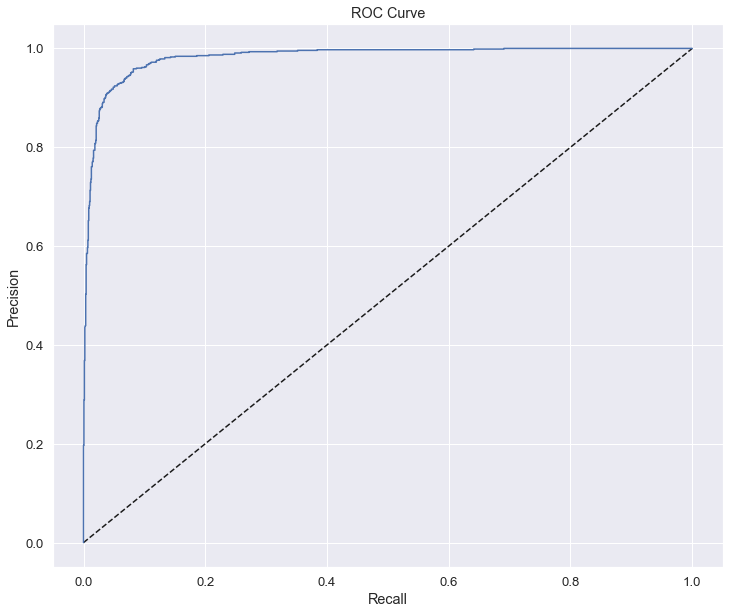

AUC Score: 0.9825347291167082


In [104]:
fpr, tpr, threshold = metrics.roc_curve(y_test, net.predict(x_test))
pyplot.subplots(figsize=(12, 10))
pyplot.plot([0,1], [0, 1], "k--")
pyplot.plot(fpr, tpr)
pyplot.xlabel("Recall")
pyplot.ylabel("Precision")
pyplot.title("ROC Curve")
pyplot.show()
auc = metrics.auc(fpr, tpr)
auc_list["Rede Neural Multicamadas"] = auc
print("AUC Score:", auc)

# Comparação Entre Modelos

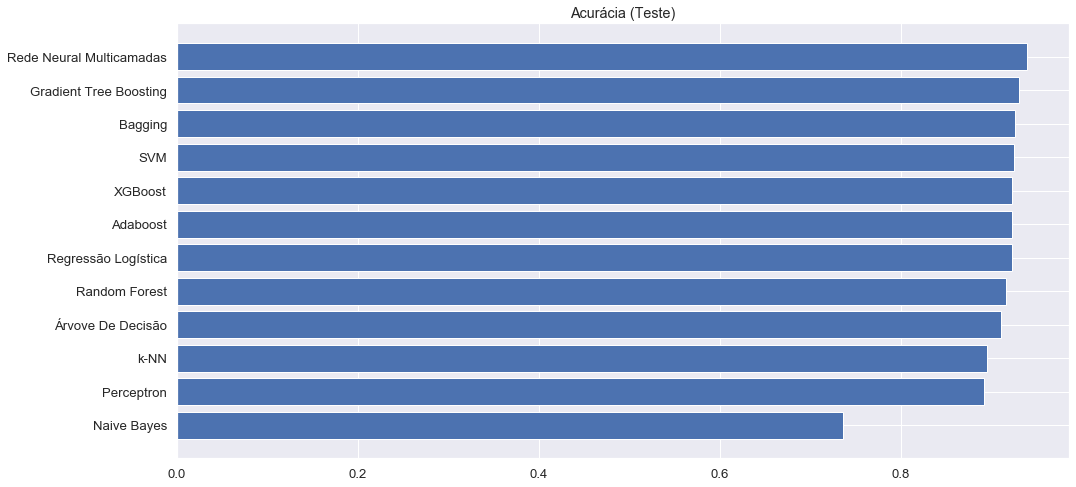

In [105]:
z = sorted(models_list.items(), key=lambda x: x[1])
zlist = list(zip(*z))
pyplot.subplots(figsize=(16, 8))
pyplot.barh(zlist[0], zlist[1])
pyplot.title("Acurácia (Teste)")
pyplot.show()

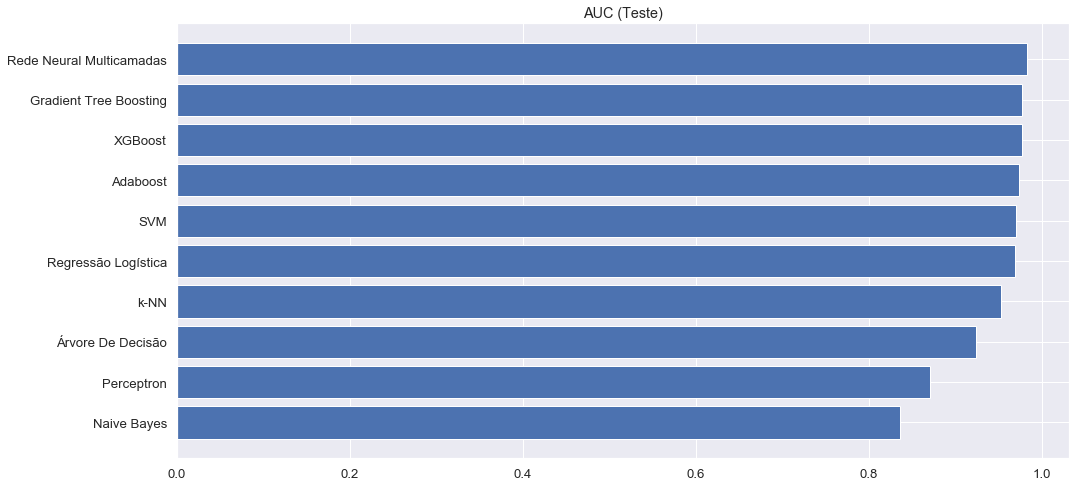

In [106]:
z = sorted(auc_list.items(), key=lambda x: x[1])
zlist = list(zip(*z))
pyplot.subplots(figsize=(16, 8))
pyplot.barh(zlist[0], zlist[1])
pyplot.title("AUC (Teste)")
pyplot.show()